##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 电影评论文本分类

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/keras/text_classification"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png"> 在 TensorFlow.org 上查看</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/text_classification.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/text_classification.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/keras/text_classification.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

本教程演示了从存储在磁盘上的纯文本文件开始的文本分类。您将训练一个二元分类器对 IMDB 数据集执行情感分析。在笔记本的最后，有一个练习供您尝试，您将在其中训练一个多类分类器来预测 Stack Overflow 上编程问题的标签。


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


2023-11-08 00:06:16.980388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 00:06:16.980452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 00:06:16.982190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print(tf.__version__)

2.15.0-rc1


## 情感分析

此笔记本训练了一个情感分析模型，利用评论文本将电影评论分类为*正面*或*负面*评价。这是一个*二元*（或二类）分类示例，也是一个重要且应用广泛的机器学习问题。

您将使用 [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)，其中包含 [Internet Movie Database](https://www.imdb.com/) 中的 50,000 条电影评论文本 。我们将这些评论分为两组，其中 25,000 条用于训练，另外 25,000 条用于测试。训练集和测试集是*均衡的*，也就是说其中包含相等数量的正面评价和负面评价。


### 下载并探索 IMDB 数据集

我们下载并提取数据集，然后浏览一下目录结构。

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 0s

   40960/84125825 [..............................] - ETA: 3:14

  106496/84125825 [..............................] - ETA: 2:29

  188416/84125825 [..............................] - ETA: 2:06

  303104/84125825 [..............................] - ETA: 1:44

  450560/84125825 [..............................] - ETA: 1:27

  614400/84125825 [..............................] - ETA: 1:17

  827392/84125825 [..............................] - ETA: 1:06

 1056768/84125825 [..............................] - ETA: 59s 

 1318912/84125825 [..............................] - ETA: 53s

 1613824/84125825 [..............................] - ETA: 48s

 1777664/84125825 [..............................] - ETA: 46s

 1974272/84125825 [..............................] - ETA: 45s

 2351104/84125825 [..............................] - ETA: 41s

 2482176/84125825 [..............................] - ETA: 40s

 2744320/84125825 [..............................] - ETA: 39s

 3006464/84125825 [>.............................] - ETA: 38s

 3268608/84125825 [>.............................] - ETA: 37s

 3440640/84125825 [>.............................] - ETA: 36s

 3678208/84125825 [>.............................] - ETA: 36s

 3874816/84125825 [>.............................] - ETA: 35s

 4120576/84125825 [>.............................] - ETA: 34s

 4399104/84125825 [>.............................] - ETA: 34s

 4562944/84125825 [>.............................] - ETA: 33s

 4841472/84125825 [>.............................] - ETA: 33s

 5021696/84125825 [>.............................] - ETA: 32s

 5300224/84125825 [>.............................] - ETA: 32s

 5480448/84125825 [>.............................] - ETA: 31s

 5758976/84125825 [=>............................] - ETA: 31s

 5955584/84125825 [=>............................] - ETA: 31s

 6234112/84125825 [=>............................] - ETA: 30s

 6430720/84125825 [=>............................] - ETA: 30s

 6709248/84125825 [=>............................] - ETA: 30s

 6905856/84125825 [=>............................] - ETA: 29s

 7184384/84125825 [=>............................] - ETA: 29s

 7397376/84125825 [=>............................] - ETA: 29s

 7675904/84125825 [=>............................] - ETA: 28s

 7888896/84125825 [=>............................] - ETA: 28s

 8167424/84125825 [=>............................] - ETA: 28s

 8380416/84125825 [=>............................] - ETA: 27s

 8675328/84125825 [==>...........................] - ETA: 27s

 8888320/84125825 [==>...........................] - ETA: 27s

 9183232/84125825 [==>...........................] - ETA: 27s

 9396224/84125825 [==>...........................] - ETA: 26s

 9691136/84125825 [==>...........................] - ETA: 26s

 9904128/84125825 [==>...........................] - ETA: 26s

10199040/84125825 [==>...........................] - ETA: 26s

10428416/84125825 [==>...........................] - ETA: 25s

10706944/84125825 [==>...........................] - ETA: 25s

10936320/84125825 [==>...........................] - ETA: 25s

11231232/84125825 [===>..........................] - ETA: 25s

11460608/84125825 [===>..........................] - ETA: 24s

11739136/84125825 [===>..........................] - ETA: 24s

11968512/84125825 [===>..........................] - ETA: 24s

12263424/84125825 [===>..........................] - ETA: 24s

12492800/84125825 [===>..........................] - ETA: 24s

12771328/84125825 [===>..........................] - ETA: 23s

12967936/84125825 [===>..........................] - ETA: 23s

13213696/84125825 [===>..........................] - ETA: 23s

13492224/84125825 [===>..........................] - ETA: 23s

13754368/84125825 [===>..........................] - ETA: 23s

14016512/84125825 [===>..........................] - ETA: 23s

14262272/84125825 [====>.........................] - ETA: 22s

14524416/84125825 [====>.........................] - ETA: 22s

14770176/84125825 [====>.........................] - ETA: 22s

15048704/84125825 [====>.........................] - ETA: 22s

15294464/84125825 [====>.........................] - ETA: 22s

15572992/84125825 [====>.........................] - ETA: 22s

15818752/84125825 [====>.........................] - ETA: 22s

16097280/84125825 [====>.........................] - ETA: 22s

16343040/84125825 [====>.........................] - ETA: 21s

16621568/84125825 [====>.........................] - ETA: 21s

16883712/84125825 [=====>........................] - ETA: 21s

17145856/84125825 [=====>........................] - ETA: 21s

17408000/84125825 [=====>........................] - ETA: 21s

17670144/84125825 [=====>........................] - ETA: 21s

17866752/84125825 [=====>........................] - ETA: 21s

18128896/84125825 [=====>........................] - ETA: 20s

18358272/84125825 [=====>........................] - ETA: 20s

18653184/84125825 [=====>........................] - ETA: 20s

18882560/84125825 [=====>........................] - ETA: 20s

19177472/84125825 [=====>........................] - ETA: 20s

19406848/84125825 [=====>........................] - ETA: 20s

19685376/84125825 [======>.......................] - ETA: 20s

19931136/84125825 [======>.......................] - ETA: 20s

20144128/84125825 [======>.......................] - ETA: 20s

20389888/84125825 [======>.......................] - ETA: 19s

20570112/84125825 [======>.......................] - ETA: 19s

20799488/84125825 [======>.......................] - ETA: 19s

21094400/84125825 [======>.......................] - ETA: 19s

21323776/84125825 [======>.......................] - ETA: 19s

21602304/84125825 [======>.......................] - ETA: 19s

21782528/84125825 [======>.......................] - ETA: 19s

22028288/84125825 [======>.......................] - ETA: 19s

22306816/84125825 [======>.......................] - ETA: 19s

22552576/84125825 [=======>......................] - ETA: 19s

22831104/84125825 [=======>......................] - ETA: 18s

23011328/84125825 [=======>......................] - ETA: 18s

23257088/84125825 [=======>......................] - ETA: 18s

23535616/84125825 [=======>......................] - ETA: 18s

23715840/84125825 [=======>......................] - ETA: 18s

23961600/84125825 [=======>......................] - ETA: 18s

24256512/84125825 [=======>......................] - ETA: 18s

24453120/84125825 [=======>......................] - ETA: 18s

24649728/84125825 [=======>......................] - ETA: 18s

24846336/84125825 [=======>......................] - ETA: 18s

25141248/84125825 [=======>......................] - ETA: 17s

25354240/84125825 [========>.....................] - ETA: 17s

25567232/84125825 [========>.....................] - ETA: 17s

25862144/84125825 [========>.....................] - ETA: 17s

26075136/84125825 [========>.....................] - ETA: 17s

26288128/84125825 [========>.....................] - ETA: 17s

26583040/84125825 [========>.....................] - ETA: 17s

26828800/84125825 [========>.....................] - ETA: 17s

27140096/84125825 [========>.....................] - ETA: 17s

27385856/84125825 [========>.....................] - ETA: 17s

27697152/84125825 [========>.....................] - ETA: 16s

27942912/84125825 [========>.....................] - ETA: 16s

28254208/84125825 [=========>....................] - ETA: 16s

28499968/84125825 [=========>....................] - ETA: 16s

28811264/84125825 [=========>....................] - ETA: 16s

29073408/84125825 [=========>....................] - ETA: 16s

29384704/84125825 [=========>....................] - ETA: 16s

29646848/84125825 [=========>....................] - ETA: 16s

29958144/84125825 [=========>....................] - ETA: 16s

30220288/84125825 [=========>....................] - ETA: 15s

30547968/84125825 [=========>....................] - ETA: 15s

30810112/84125825 [=========>....................] - ETA: 15s

31137792/84125825 [==========>...................] - ETA: 15s

31416320/84125825 [==========>...................] - ETA: 15s

31744000/84125825 [==========>...................] - ETA: 15s

32022528/84125825 [==========>...................] - ETA: 15s

32366592/84125825 [==========>...................] - ETA: 15s

32628736/84125825 [==========>...................] - ETA: 15s

32972800/84125825 [==========>...................] - ETA: 14s

33251328/84125825 [==========>...................] - ETA: 14s

33611776/84125825 [==========>...................] - ETA: 14s

33890304/84125825 [===========>..................] - ETA: 14s

34250752/84125825 [===========>..................] - ETA: 14s

34496512/84125825 [===========>..................] - ETA: 14s

34758656/84125825 [===========>..................] - ETA: 14s

35135488/84125825 [===========>..................] - ETA: 14s

35430400/84125825 [===========>..................] - ETA: 13s

35807232/84125825 [===========>..................] - ETA: 13s

36052992/84125825 [===========>..................] - ETA: 13s

36347904/84125825 [===========>..................] - ETA: 13s

36724736/84125825 [============>.................] - ETA: 13s

36986880/84125825 [============>.................] - ETA: 13s

37281792/84125825 [============>.................] - ETA: 13s

37675008/84125825 [============>.................] - ETA: 13s

37937152/84125825 [============>.................] - ETA: 12s

38248448/84125825 [============>.................] - ETA: 12s

38658048/84125825 [============>.................] - ETA: 12s

38936576/84125825 [============>.................] - ETA: 12s

39247872/84125825 [============>.................] - ETA: 12s

39673856/84125825 [=============>................] - ETA: 12s

39968768/84125825 [=============>................] - ETA: 12s

40296448/84125825 [=============>................] - ETA: 12s

40722432/84125825 [=============>................] - ETA: 11s

41017344/84125825 [=============>................] - ETA: 11s

41361408/84125825 [=============>................] - ETA: 11s

41803776/84125825 [=============>................] - ETA: 11s

42131456/84125825 [==============>...............] - ETA: 11s

42475520/84125825 [==============>...............] - ETA: 11s

42688512/84125825 [==============>...............] - ETA: 11s

43212800/84125825 [==============>...............] - ETA: 10s

43524096/84125825 [==============>...............] - ETA: 10s

43786240/84125825 [==============>...............] - ETA: 10s

44032000/84125825 [==============>...............] - ETA: 10s

44359680/84125825 [==============>...............] - ETA: 10s

44638208/84125825 [==============>...............] - ETA: 10s

44900352/84125825 [===============>..............] - ETA: 10s

45228032/84125825 [===============>..............] - ETA: 10s

45506560/84125825 [===============>..............] - ETA: 10s

45785088/84125825 [===============>..............] - ETA: 10s

46129152/84125825 [===============>..............] - ETA: 10s

46424064/84125825 [===============>..............] - ETA: 9s 

46702592/84125825 [===============>..............] - ETA: 9s

47063040/84125825 [===============>..............] - ETA: 9s

47357952/84125825 [===============>..............] - ETA: 9s

47620096/84125825 [===============>..............] - ETA: 9s

47898624/84125825 [================>.............] - ETA: 9s

48259072/84125825 [================>.............] - ETA: 9s

48570368/84125825 [================>.............] - ETA: 9s

48881664/84125825 [================>.............] - ETA: 9s

49258496/84125825 [================>.............] - ETA: 9s

49553408/84125825 [================>.............] - ETA: 9s

49831936/84125825 [================>.............] - ETA: 8s

50126848/84125825 [================>.............] - ETA: 8s

50520064/84125825 [=================>............] - ETA: 8s

50831360/84125825 [=================>............] - ETA: 8s

51109888/84125825 [=================>............] - ETA: 8s

51421184/84125825 [=================>............] - ETA: 8s

51814400/84125825 [=================>............] - ETA: 8s

52125696/84125825 [=================>............] - ETA: 8s

52412416/84125825 [=================>............] - ETA: 8s

52731904/84125825 [=================>............] - ETA: 8s

53125120/84125825 [=================>............] - ETA: 7s

53452800/84125825 [==================>...........] - ETA: 7s

53731328/84125825 [==================>...........] - ETA: 7s

54059008/84125825 [==================>...........] - ETA: 7s

54468608/84125825 [==================>...........] - ETA: 7s

54796288/84125825 [==================>...........] - ETA: 7s

55091200/84125825 [==================>...........] - ETA: 7s

55402496/84125825 [==================>...........] - ETA: 7s

55828480/84125825 [==================>...........] - ETA: 7s

56156160/84125825 [===================>..........] - ETA: 7s

56451072/84125825 [===================>..........] - ETA: 6s

56778752/84125825 [===================>..........] - ETA: 6s

57204736/84125825 [===================>..........] - ETA: 6s

57499648/84125825 [===================>..........] - ETA: 6s

57827328/84125825 [===================>..........] - ETA: 6s

58155008/84125825 [===================>..........] - ETA: 6s

58597376/84125825 [===================>..........] - ETA: 6s

58941440/84125825 [====================>.........] - ETA: 6s

59285504/84125825 [====================>.........] - ETA: 6s

59727872/84125825 [====================>.........] - ETA: 6s

60071936/84125825 [====================>.........] - ETA: 5s

60399616/84125825 [====================>.........] - ETA: 5s

60841984/84125825 [====================>.........] - ETA: 5s

61136896/84125825 [====================>.........] - ETA: 5s

61464576/84125825 [====================>.........] - ETA: 5s

61808640/84125825 [=====================>........] - ETA: 5s

62251008/84125825 [=====================>........] - ETA: 5s

62545920/84125825 [=====================>........] - ETA: 5s

62840832/84125825 [=====================>........] - ETA: 5s

63234048/84125825 [=====================>........] - ETA: 5s

63676416/84125825 [=====================>........] - ETA: 4s

63971328/84125825 [=====================>........] - ETA: 4s

64266240/84125825 [=====================>........] - ETA: 4s

64659456/84125825 [======================>.......] - ETA: 4s

65118208/84125825 [======================>.......] - ETA: 4s

65445888/84125825 [======================>.......] - ETA: 4s

65806336/84125825 [======================>.......] - ETA: 4s

66265088/84125825 [======================>.......] - ETA: 4s

66592768/84125825 [======================>.......] - ETA: 4s

66953216/84125825 [======================>.......] - ETA: 4s

67411968/84125825 [=======================>......] - ETA: 3s

67739648/84125825 [=======================>......] - ETA: 3s

68100096/84125825 [=======================>......] - ETA: 3s

68558848/84125825 [=======================>......] - ETA: 3s

68886528/84125825 [=======================>......] - ETA: 3s

69246976/84125825 [=======================>......] - ETA: 3s

69705728/84125825 [=======================>......] - ETA: 3s

70033408/84125825 [=======================>......] - ETA: 3s

70393856/84125825 [========================>.....] - ETA: 3s

70852608/84125825 [========================>.....] - ETA: 3s

71180288/84125825 [========================>.....] - ETA: 3s

71540736/84125825 [========================>.....] - ETA: 2s

71999488/84125825 [========================>.....] - ETA: 2s

72327168/84125825 [========================>.....] - ETA: 2s

72687616/84125825 [========================>.....] - ETA: 2s

73146368/84125825 [=========================>....] - ETA: 2s

73474048/84125825 [=========================>....] - ETA: 2s

73834496/84125825 [=========================>....] - ETA: 2s

74293248/84125825 [=========================>....] - ETA: 2s

74620928/84125825 [=========================>....] - ETA: 2s

74981376/84125825 [=========================>....] - ETA: 2s

75440128/84125825 [=========================>....] - ETA: 1s

75784192/84125825 [==========================>...] - ETA: 1s

76128256/84125825 [==========================>...] - ETA: 1s

76587008/84125825 [==========================>...] - ETA: 1s

76931072/84125825 [==========================>...] - ETA: 1s

77275136/84125825 [==========================>...] - ETA: 1s

77733888/84125825 [==========================>...] - ETA: 1s

78077952/84125825 [==========================>...] - ETA: 1s

78422016/84125825 [==========================>...] - ETA: 1s

78880768/84125825 [===========================>..] - ETA: 1s

79273984/84125825 [===========================>..] - ETA: 1s

79732736/84125825 [===========================>..] - ETA: 0s

80027648/84125825 [===========================>..] - ETA: 0s

80420864/84125825 [===========================>..] - ETA: 0s

80879616/84125825 [===========================>..] - ETA: 0s

81174528/84125825 [===========================>..] - ETA: 0s

81518592/84125825 [============================>.] - ETA: 0s

81616896/84125825 [============================>.] - ETA: 0s

82141184/84125825 [============================>.] - ETA: 0s

82370560/84125825 [============================>.] - ETA: 0s

82599936/84125825 [============================>.] - ETA: 0s

82829312/84125825 [============================>.] - ETA: 0s

83091456/84125825 [============================>.] - ETA: 0s

83337216/84125825 [============================>.] - ETA: 0s

83615744/84125825 [============================>.] - ETA: 0s

83845120/84125825 [============================>.] - ETA: 0s

84074496/84125825 [============================>.] - ETA: 0s

84125825/84125825 [==============================] - 19s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'neg',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsup',
 'pos']

`aclImdb/train/pos` 和 `aclImdb/train/neg` 目录包含许多文本文件，每个文件都是一条电影评论。我们来看看其中的一条评论。

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### 加载数据集

接下来，您将从磁盘加载数据并将其准备为适合训练的格式。为此，您将使用有用的 [text_dataset_from_directory](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) 实用工具，它期望的目录结构如下所示。

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

要准备用于二元分类的数据集，磁盘上需要有两个文件夹，分别对应于 `class_a` 和 `class_b`。这些将是正面和负面的电影评论，可以在 `aclImdb/train/pos` 和 `aclImdb/train/neg` 中找到。由于 IMDB 数据集包含其他文件夹，因此您需要在使用此实用工具之前将其移除。

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

接下来，您将使用 `text_dataset_from_directory` 实用工具创建带标签的 `tf.data.Dataset`。[tf.data](https://tensorflow.google.cn/guide/data) 是一组强大的数据处理工具。

运行机器学习实验时，最佳做法是将数据集拆成三份：[训练](https://developers.google.com/machine-learning/glossary#training_set)、[验证](https://developers.google.com/machine-learning/glossary#validation_set) 和 [测试](https://developers.google.com/machine-learning/glossary#test-set)。

IMDB 数据集已经分成训练集和测试集，但缺少验证集。我们来通过下面的 `validation_split` 参数，使用 80:20 拆分训练数据来创建验证集。

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.


Using 20000 files for training.


如上所示，训练文件夹中有 25,000 个样本，您将使用其中的 80%（或 20,000 个）进行训练。稍后您将看到，您可以通过将数据集直接传递给 `model.fit` 来训练模型。如果您不熟悉 `tf.data`，还可以遍历数据集并打印出一些样本，如下所示。

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

请注意，评论包含原始文本（带有标点符号和偶尔出现的 HTML 代码，如 `<br/>`）。我们将在以下部分展示如何处理这些问题。

标签为 0 或 1。要查看它们与正面和负面电影评论的对应关系，可以查看数据集上的 `class_names` 属性。


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


接下来，您将创建验证数据集和测试数据集。您将使用训练集中剩余的 5,000 条评论进行验证。

注：使用 `validation_split` 和 `subset` 参数时，请确保要么指定随机种子，要么传递 `shuffle=False`，这样验证拆分和训练拆分就不会重叠。

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.


Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### 准备用于训练的数据集

接下来，您将使用有用的 `tf.keras.layers.TextVectorization` 层对数据进行标准化、词例化和向量化。

标准化是指对文本进行预处理，通常是移除标点符号或 HTML 元素以简化数据集。词例化是指将字符串分割成词例（例如，通过空格将句子分割成单个单词）。向量化是指将词例转换为数字，以便将它们输入神经网络。所有这些任务都可以通过这个层完成。

正如您在上面看到的，评论包含各种 HTML 代码，例如 `<br />`。`TextVectorization` 层（默认情况下会将文本转换为小写并去除标点符号，但不会去除 HTML）中的默认标准化程序不会移除这些代码。您将编写一个自定义标准化函数来移除 HTML。

注：为了防止[训练-测试偏差](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)（也称为训练-应用偏差），在训练和测试时间对数据进行相同的预处理非常重要。为此，可以将 `TextVectorization` 层直接包含在模型中，如本教程后面所示。

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

<br>接下来，您将创建一个 `TextVectorization` 层。您将使用该层对我们的数据进行标准化、词例化和向量化。您将 `output_mode` 设置为 `int` 以便为每个词例创建唯一的整数索引。

请注意，您使用的是默认拆分函数，以及您在上面定义的自定义标准化函数。您还将为模型定义一些常量，例如显式的最大 `sequence_length`，这会使层将序列填充或截断为精确的 `sequence_length` 值。

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

接下来，您将调用 `adapt` 以使预处理层的状态适合数据集。这会使模型构建字符串到整数的索引。

注：在调用时请务必仅使用您的训练数据（使用测试集会泄漏信息）。

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

我们来创建一个函数来查看使用该层预处理一些数据的结果。

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

正如您在上面看到的，每个词例都被一个整数替换了。您可以通过在该层上调用 `.get_vocabulary()` 来查找每个整数对应的词例（字符串）。

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


差不多可以训练您的模型了。作为最后的预处理步骤，将之前创建的 TextVectorization 层应用于训练数据集、验证数据集和测试数据集。

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### 配置数据集以提高性能

以下是加载数据时应该使用的两种重要方法，以确保 I/O 不会阻塞。

从磁盘加载后，`.cache()` 会将数据保存在内存中。这将确保数据集在训练模型时不会成为瓶颈。如果您的数据集太大而无法放入内存，也可以使用此方法创建高性能的磁盘缓存，这比许多小文件的读取效率更高。

`prefetch()` 会在训练时将数据预处理和模型执行重叠。

您可以在[数据性能指南](https://tensorflow.google.cn/guide/data_performance)中深入了解这两种方法，以及如何将数据缓存到磁盘。

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 创建模型

是时候创建您的神经网络了：

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 16)          160016    


 dropout (Dropout)           (None, None, 16)          0         


 global_average_pooling1d (  (None, 16)                0         


 GlobalAveragePooling1D)                                         


 dropout_1 (Dropout)         (None, 16)                0         


 dense (Dense)               (None, 1)                 17        


Total params: 160033 (625.13 KB)


Trainable params: 160033 (625.13 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


层按顺序堆叠以构建分类器：

1. 第一个层是 `Embedding` 层。此层采用整数编码的评论，并查找每个单词索引的嵌入向量。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：`(batch, sequence, embedding)`。要详细了解嵌入向量，请参阅[单词嵌入向量](https://tensorflow.google.cn/text/guide/word_embeddings)教程。
2. 接下来，`GlobalAveragePooling1D` 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
3. 该定长输出向量通过一个有 16 个隐层单元的全连接（`Dense`）层传输。
4. 最后一层与单个输出结点密集连接。使用 `Sigmoid` 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

### 损失函数与优化器

一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 `binary_crossentropy` 损失函数。

这不是损失函数的唯一选择，例如，您可以选择 `mean_squared_error` 。但是，一般来说 `binary_crossentropy` 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，指的是度量 ground-truth 分布与预测值之间的“距离”。

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### 训练模型

以 512 个样本的 mini-batch 大小迭代 40 个 epoch 来训练模型。这是指对 `x_train` 和 `y_train` 张量中所有样本的的 40 次迭代。在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）：

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


I0000 00:00:1699402032.417606  600522 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/625 [..............................] - ETA: 24:22 - loss: 0.6924 - binary_accuracy: 0.5625

  2/625 [..............................] - ETA: 1:42 - loss: 0.6936 - binary_accuracy: 0.4375 

  3/625 [..............................] - ETA: 1:42 - loss: 0.6929 - binary_accuracy: 0.4896

  4/625 [..............................] - ETA: 1:41 - loss: 0.6928 - binary_accuracy: 0.5078

  5/625 [..............................] - ETA: 1:40 - loss: 0.6922 - binary_accuracy: 0.5375

  6/625 [..............................] - ETA: 1:40 - loss: 0.6922 - binary_accuracy: 0.5469

  7/625 [..............................] - ETA: 1:40 - loss: 0.6926 - binary_accuracy: 0.5312

  8/625 [..............................] - ETA: 1:40 - loss: 0.6929 - binary_accuracy: 0.5195

  9/625 [..............................] - ETA: 1:40 - loss: 0.6929 - binary_accuracy: 0.5104

 10/625 [..............................] - ETA: 1:40 - loss: 0.6931 - binary_accuracy: 0.5031

 11/625 [..............................] - ETA: 1:40 - loss: 0.6930 - binary_accuracy: 0.5085

 12/625 [..............................] - ETA: 1:39 - loss: 0.6929 - binary_accuracy: 0.5078

 13/625 [..............................] - ETA: 1:39 - loss: 0.6929 - binary_accuracy: 0.5072

 14/625 [..............................] - ETA: 1:39 - loss: 0.6931 - binary_accuracy: 0.5045

 15/625 [..............................] - ETA: 1:39 - loss: 0.6931 - binary_accuracy: 0.5083

 16/625 [..............................] - ETA: 1:39 - loss: 0.6929 - binary_accuracy: 0.5176

 17/625 [..............................] - ETA: 1:38 - loss: 0.6931 - binary_accuracy: 0.5092

 18/625 [..............................] - ETA: 1:38 - loss: 0.6931 - binary_accuracy: 0.5087

 19/625 [..............................] - ETA: 1:38 - loss: 0.6932 - binary_accuracy: 0.5033

 21/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5074

 22/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5085

 23/625 [>.............................] - ETA: 1:33 - loss: 0.6931 - binary_accuracy: 0.5136

 24/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5091

 25/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5088

 26/625 [>.............................] - ETA: 1:33 - loss: 0.6931 - binary_accuracy: 0.5120

 27/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5035

 28/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5045

 29/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5065

 30/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5073

 31/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5050

 32/625 [>.............................] - ETA: 1:33 - loss: 0.6932 - binary_accuracy: 0.5049

 33/625 [>.............................] - ETA: 1:33 - loss: 0.6931 - binary_accuracy: 0.5066

 35/625 [>.............................] - ETA: 1:30 - loss: 0.6931 - binary_accuracy: 0.5071

 36/625 [>.............................] - ETA: 1:30 - loss: 0.6930 - binary_accuracy: 0.5087

 37/625 [>.............................] - ETA: 1:30 - loss: 0.6930 - binary_accuracy: 0.5076

 38/625 [>.............................] - ETA: 1:30 - loss: 0.6930 - binary_accuracy: 0.5074

 39/625 [>.............................] - ETA: 1:30 - loss: 0.6930 - binary_accuracy: 0.5088

 40/625 [>.............................] - ETA: 1:30 - loss: 0.6929 - binary_accuracy: 0.5148

 41/625 [>.............................] - ETA: 1:30 - loss: 0.6929 - binary_accuracy: 0.5183

 42/625 [=>............................] - ETA: 1:30 - loss: 0.6928 - binary_accuracy: 0.5223

 43/625 [=>............................] - ETA: 1:30 - loss: 0.6928 - binary_accuracy: 0.5247

 44/625 [=>............................] - ETA: 1:30 - loss: 0.6927 - binary_accuracy: 0.5305

 46/625 [=>............................] - ETA: 1:27 - loss: 0.6926 - binary_accuracy: 0.5333

 47/625 [=>............................] - ETA: 1:27 - loss: 0.6926 - binary_accuracy: 0.5366

 48/625 [=>............................] - ETA: 1:27 - loss: 0.6925 - binary_accuracy: 0.5391

 49/625 [=>............................] - ETA: 1:27 - loss: 0.6925 - binary_accuracy: 0.5427

 50/625 [=>............................] - ETA: 1:27 - loss: 0.6925 - binary_accuracy: 0.5425

 51/625 [=>............................] - ETA: 1:27 - loss: 0.6925 - binary_accuracy: 0.5423

 52/625 [=>............................] - ETA: 1:27 - loss: 0.6924 - binary_accuracy: 0.5445

 54/625 [=>............................] - ETA: 1:26 - loss: 0.6923 - binary_accuracy: 0.5480

 55/625 [=>............................] - ETA: 1:26 - loss: 0.6923 - binary_accuracy: 0.5472

 56/625 [=>............................] - ETA: 1:26 - loss: 0.6923 - binary_accuracy: 0.5463

 57/625 [=>............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5461

 58/625 [=>............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5463

 59/625 [=>............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5456

 60/625 [=>............................] - ETA: 1:25 - loss: 0.6922 - binary_accuracy: 0.5469

 61/625 [=>............................] - ETA: 1:25 - loss: 0.6922 - binary_accuracy: 0.5461

 62/625 [=>............................] - ETA: 1:25 - loss: 0.6920 - binary_accuracy: 0.5484

 63/625 [==>...........................] - ETA: 1:25 - loss: 0.6920 - binary_accuracy: 0.5481

 64/625 [==>...........................] - ETA: 1:25 - loss: 0.6920 - binary_accuracy: 0.5469

 65/625 [==>...........................] - ETA: 1:25 - loss: 0.6920 - binary_accuracy: 0.5471

 68/625 [==>...........................] - ETA: 1:22 - loss: 0.6920 - binary_accuracy: 0.5437

 70/625 [==>...........................] - ETA: 1:21 - loss: 0.6920 - binary_accuracy: 0.5424

 71/625 [==>...........................] - ETA: 1:21 - loss: 0.6920 - binary_accuracy: 0.5423

 73/625 [==>...........................] - ETA: 1:20 - loss: 0.6920 - binary_accuracy: 0.5407

 74/625 [==>...........................] - ETA: 1:19 - loss: 0.6919 - binary_accuracy: 0.5414

 76/625 [==>...........................] - ETA: 1:18 - loss: 0.6918 - binary_accuracy: 0.5432

 77/625 [==>...........................] - ETA: 1:18 - loss: 0.6917 - binary_accuracy: 0.5422

 78/625 [==>...........................] - ETA: 1:18 - loss: 0.6918 - binary_accuracy: 0.5397

 79/625 [==>...........................] - ETA: 1:18 - loss: 0.6917 - binary_accuracy: 0.5407

 80/625 [==>...........................] - ETA: 1:18 - loss: 0.6917 - binary_accuracy: 0.5410

 83/625 [==>...........................] - ETA: 1:16 - loss: 0.6917 - binary_accuracy: 0.5384

 84/625 [===>..........................] - ETA: 1:16 - loss: 0.6917 - binary_accuracy: 0.5387

 85/625 [===>..........................] - ETA: 1:16 - loss: 0.6917 - binary_accuracy: 0.5379

 86/625 [===>..........................] - ETA: 1:16 - loss: 0.6916 - binary_accuracy: 0.5385

 88/625 [===>..........................] - ETA: 1:15 - loss: 0.6916 - binary_accuracy: 0.5376

 89/625 [===>..........................] - ETA: 1:15 - loss: 0.6917 - binary_accuracy: 0.5351

 90/625 [===>..........................] - ETA: 1:15 - loss: 0.6917 - binary_accuracy: 0.5344

 91/625 [===>..........................] - ETA: 1:15 - loss: 0.6917 - binary_accuracy: 0.5340

 93/625 [===>..........................] - ETA: 1:14 - loss: 0.6917 - binary_accuracy: 0.5319

 96/625 [===>..........................] - ETA: 1:12 - loss: 0.6918 - binary_accuracy: 0.5306

 98/625 [===>..........................] - ETA: 1:11 - loss: 0.6917 - binary_accuracy: 0.5306

101/625 [===>..........................] - ETA: 1:10 - loss: 0.6917 - binary_accuracy: 0.5269

102/625 [===>..........................] - ETA: 1:10 - loss: 0.6917 - binary_accuracy: 0.5263

104/625 [===>..........................] - ETA: 1:09 - loss: 0.6917 - binary_accuracy: 0.5264

105/625 [====>.........................] - ETA: 1:09 - loss: 0.6917 - binary_accuracy: 0.5259

107/625 [====>.........................] - ETA: 1:08 - loss: 0.6917 - binary_accuracy: 0.5260

108/625 [====>.........................] - ETA: 1:08 - loss: 0.6916 - binary_accuracy: 0.5275

109/625 [====>.........................] - ETA: 1:08 - loss: 0.6916 - binary_accuracy: 0.5284

110/625 [====>.........................] - ETA: 1:08 - loss: 0.6916 - binary_accuracy: 0.5290

111/625 [====>.........................] - ETA: 1:08 - loss: 0.6916 - binary_accuracy: 0.5293

112/625 [====>.........................] - ETA: 1:08 - loss: 0.6916 - binary_accuracy: 0.5293

113/625 [====>.........................] - ETA: 1:08 - loss: 0.6916 - binary_accuracy: 0.5285

115/625 [====>.........................] - ETA: 1:07 - loss: 0.6916 - binary_accuracy: 0.5293

117/625 [====>.........................] - ETA: 1:07 - loss: 0.6916 - binary_accuracy: 0.5299

119/625 [====>.........................] - ETA: 1:06 - loss: 0.6916 - binary_accuracy: 0.5310

120/625 [====>.........................] - ETA: 1:06 - loss: 0.6915 - binary_accuracy: 0.5320

121/625 [====>.........................] - ETA: 1:06 - loss: 0.6915 - binary_accuracy: 0.5331

122/625 [====>.........................] - ETA: 1:06 - loss: 0.6915 - binary_accuracy: 0.5343

124/625 [====>.........................] - ETA: 1:05 - loss: 0.6914 - binary_accuracy: 0.5348

125/625 [=====>........................] - ETA: 1:05 - loss: 0.6914 - binary_accuracy: 0.5355

127/625 [=====>........................] - ETA: 1:05 - loss: 0.6914 - binary_accuracy: 0.5376

130/625 [=====>........................] - ETA: 1:03 - loss: 0.6913 - binary_accuracy: 0.5421

131/625 [=====>........................] - ETA: 1:03 - loss: 0.6913 - binary_accuracy: 0.5441

134/625 [=====>........................] - ETA: 1:02 - loss: 0.6912 - binary_accuracy: 0.5480

136/625 [=====>........................] - ETA: 1:01 - loss: 0.6912 - binary_accuracy: 0.5492

137/625 [=====>........................] - ETA: 1:01 - loss: 0.6912 - binary_accuracy: 0.5509

139/625 [=====>........................] - ETA: 1:01 - loss: 0.6911 - binary_accuracy: 0.5531

142/625 [=====>........................] - ETA: 1:00 - loss: 0.6911 - binary_accuracy: 0.5561

144/625 [=====>........................] - ETA: 59s - loss: 0.6910 - binary_accuracy: 0.5584 

145/625 [=====>........................] - ETA: 59s - loss: 0.6910 - binary_accuracy: 0.5593

146/625 [======>.......................] - ETA: 59s - loss: 0.6910 - binary_accuracy: 0.5601

147/625 [======>.......................] - ETA: 59s - loss: 0.6910 - binary_accuracy: 0.5606

148/625 [======>.......................] - ETA: 59s - loss: 0.6910 - binary_accuracy: 0.5612

149/625 [======>.......................] - ETA: 59s - loss: 0.6910 - binary_accuracy: 0.5610

151/625 [======>.......................] - ETA: 59s - loss: 0.6909 - binary_accuracy: 0.5623

152/625 [======>.......................] - ETA: 59s - loss: 0.6909 - binary_accuracy: 0.5635

160/625 [======>.......................] - ETA: 55s - loss: 0.6907 - binary_accuracy: 0.5701

162/625 [======>.......................] - ETA: 55s - loss: 0.6906 - binary_accuracy: 0.5725

164/625 [======>.......................] - ETA: 54s - loss: 0.6906 - binary_accuracy: 0.5732

165/625 [======>.......................] - ETA: 54s - loss: 0.6906 - binary_accuracy: 0.5737

166/625 [======>.......................] - ETA: 54s - loss: 0.6905 - binary_accuracy: 0.5757

167/625 [=======>......................] - ETA: 54s - loss: 0.6905 - binary_accuracy: 0.5769

169/625 [=======>......................] - ETA: 54s - loss: 0.6904 - binary_accuracy: 0.5790

170/625 [=======>......................] - ETA: 54s - loss: 0.6904 - binary_accuracy: 0.5801

171/625 [=======>......................] - ETA: 54s - loss: 0.6904 - binary_accuracy: 0.5802

172/625 [=======>......................] - ETA: 54s - loss: 0.6904 - binary_accuracy: 0.5812

174/625 [=======>......................] - ETA: 54s - loss: 0.6903 - binary_accuracy: 0.5828

175/625 [=======>......................] - ETA: 54s - loss: 0.6903 - binary_accuracy: 0.5836

179/625 [=======>......................] - ETA: 52s - loss: 0.6902 - binary_accuracy: 0.5859

180/625 [=======>......................] - ETA: 52s - loss: 0.6902 - binary_accuracy: 0.5859

181/625 [=======>......................] - ETA: 52s - loss: 0.6902 - binary_accuracy: 0.5858

183/625 [=======>......................] - ETA: 52s - loss: 0.6901 - binary_accuracy: 0.5869

185/625 [=======>......................] - ETA: 51s - loss: 0.6901 - binary_accuracy: 0.5875

188/625 [========>.....................] - ETA: 51s - loss: 0.6900 - binary_accuracy: 0.5876

189/625 [========>.....................] - ETA: 51s - loss: 0.6900 - binary_accuracy: 0.5881

190/625 [========>.....................] - ETA: 51s - loss: 0.6899 - binary_accuracy: 0.5885

191/625 [========>.....................] - ETA: 51s - loss: 0.6899 - binary_accuracy: 0.5893

192/625 [========>.....................] - ETA: 51s - loss: 0.6899 - binary_accuracy: 0.5890

194/625 [========>.....................] - ETA: 50s - loss: 0.6899 - binary_accuracy: 0.5888

195/625 [========>.....................] - ETA: 50s - loss: 0.6899 - binary_accuracy: 0.5889

196/625 [========>.....................] - ETA: 50s - loss: 0.6898 - binary_accuracy: 0.5890

197/625 [========>.....................] - ETA: 50s - loss: 0.6899 - binary_accuracy: 0.5884

201/625 [========>.....................] - ETA: 49s - loss: 0.6897 - binary_accuracy: 0.5888

202/625 [========>.....................] - ETA: 49s - loss: 0.6897 - binary_accuracy: 0.5886

204/625 [========>.....................] - ETA: 49s - loss: 0.6897 - binary_accuracy: 0.5885

206/625 [========>.....................] - ETA: 48s - loss: 0.6897 - binary_accuracy: 0.5886

207/625 [========>.....................] - ETA: 48s - loss: 0.6897 - binary_accuracy: 0.5886

211/625 [=========>....................] - ETA: 47s - loss: 0.6895 - binary_accuracy: 0.5898

213/625 [=========>....................] - ETA: 47s - loss: 0.6895 - binary_accuracy: 0.5905

214/625 [=========>....................] - ETA: 47s - loss: 0.6895 - binary_accuracy: 0.5914

215/625 [=========>....................] - ETA: 47s - loss: 0.6894 - binary_accuracy: 0.5922

217/625 [=========>....................] - ETA: 47s - loss: 0.6893 - binary_accuracy: 0.5936

218/625 [=========>....................] - ETA: 47s - loss: 0.6893 - binary_accuracy: 0.5939

219/625 [=========>....................] - ETA: 46s - loss: 0.6893 - binary_accuracy: 0.5945

220/625 [=========>....................] - ETA: 46s - loss: 0.6893 - binary_accuracy: 0.5945

221/625 [=========>....................] - ETA: 46s - loss: 0.6892 - binary_accuracy: 0.5952

224/625 [=========>....................] - ETA: 46s - loss: 0.6891 - binary_accuracy: 0.5968

225/625 [=========>....................] - ETA: 46s - loss: 0.6891 - binary_accuracy: 0.5974

226/625 [=========>....................] - ETA: 46s - loss: 0.6890 - binary_accuracy: 0.5975

228/625 [=========>....................] - ETA: 45s - loss: 0.6890 - binary_accuracy: 0.5979

233/625 [==========>...................] - ETA: 44s - loss: 0.6888 - binary_accuracy: 0.6005

235/625 [==========>...................] - ETA: 44s - loss: 0.6888 - binary_accuracy: 0.6008

237/625 [==========>...................] - ETA: 43s - loss: 0.6887 - binary_accuracy: 0.6015

238/625 [==========>...................] - ETA: 43s - loss: 0.6886 - binary_accuracy: 0.6024

240/625 [==========>...................] - ETA: 43s - loss: 0.6886 - binary_accuracy: 0.6029

241/625 [==========>...................] - ETA: 43s - loss: 0.6885 - binary_accuracy: 0.6035

244/625 [==========>...................] - ETA: 42s - loss: 0.6884 - binary_accuracy: 0.6049

245/625 [==========>...................] - ETA: 42s - loss: 0.6884 - binary_accuracy: 0.6055

247/625 [==========>...................] - ETA: 42s - loss: 0.6883 - binary_accuracy: 0.6063

249/625 [==========>...................] - ETA: 42s - loss: 0.6883 - binary_accuracy: 0.6072

251/625 [===========>..................] - ETA: 41s - loss: 0.6882 - binary_accuracy: 0.6082

253/625 [===========>..................] - ETA: 41s - loss: 0.6882 - binary_accuracy: 0.6089

254/625 [===========>..................] - ETA: 41s - loss: 0.6881 - binary_accuracy: 0.6094

256/625 [===========>..................] - ETA: 41s - loss: 0.6881 - binary_accuracy: 0.6102

258/625 [===========>..................] - ETA: 40s - loss: 0.6880 - binary_accuracy: 0.6114

259/625 [===========>..................] - ETA: 40s - loss: 0.6879 - binary_accuracy: 0.6120

261/625 [===========>..................] - ETA: 40s - loss: 0.6879 - binary_accuracy: 0.6130

262/625 [===========>..................] - ETA: 40s - loss: 0.6878 - binary_accuracy: 0.6138

264/625 [===========>..................] - ETA: 40s - loss: 0.6877 - binary_accuracy: 0.6148

266/625 [===========>..................] - ETA: 39s - loss: 0.6876 - binary_accuracy: 0.6160

267/625 [===========>..................] - ETA: 39s - loss: 0.6876 - binary_accuracy: 0.6163

268/625 [===========>..................] - ETA: 39s - loss: 0.6876 - binary_accuracy: 0.6163

269/625 [===========>..................] - ETA: 39s - loss: 0.6875 - binary_accuracy: 0.6169

270/625 [===========>..................] - ETA: 39s - loss: 0.6875 - binary_accuracy: 0.6167

271/625 [============>.................] - ETA: 39s - loss: 0.6875 - binary_accuracy: 0.6172

275/625 [============>.................] - ETA: 39s - loss: 0.6873 - binary_accuracy: 0.6193

277/625 [============>.................] - ETA: 38s - loss: 0.6873 - binary_accuracy: 0.6192

280/625 [============>.................] - ETA: 38s - loss: 0.6871 - binary_accuracy: 0.6211

281/625 [============>.................] - ETA: 38s - loss: 0.6871 - binary_accuracy: 0.6212

284/625 [============>.................] - ETA: 37s - loss: 0.6870 - binary_accuracy: 0.6224

288/625 [============>.................] - ETA: 36s - loss: 0.6869 - binary_accuracy: 0.6237

291/625 [============>.................] - ETA: 36s - loss: 0.6868 - binary_accuracy: 0.6246

293/625 [=============>................] - ETA: 36s - loss: 0.6868 - binary_accuracy: 0.6247

301/625 [=============>................] - ETA: 34s - loss: 0.6865 - binary_accuracy: 0.6272

302/625 [=============>................] - ETA: 34s - loss: 0.6864 - binary_accuracy: 0.6276

306/625 [=============>................] - ETA: 33s - loss: 0.6863 - binary_accuracy: 0.6283

307/625 [=============>................] - ETA: 33s - loss: 0.6863 - binary_accuracy: 0.6289

308/625 [=============>................] - ETA: 33s - loss: 0.6862 - binary_accuracy: 0.6294

311/625 [=============>................] - ETA: 33s - loss: 0.6861 - binary_accuracy: 0.6301

315/625 [==============>...............] - ETA: 32s - loss: 0.6860 - binary_accuracy: 0.6305

321/625 [==============>...............] - ETA: 31s - loss: 0.6858 - binary_accuracy: 0.6317

327/625 [==============>...............] - ETA: 30s - loss: 0.6855 - binary_accuracy: 0.6332

329/625 [==============>...............] - ETA: 30s - loss: 0.6854 - binary_accuracy: 0.6340

330/625 [==============>...............] - ETA: 30s - loss: 0.6854 - binary_accuracy: 0.6344

333/625 [==============>...............] - ETA: 29s - loss: 0.6852 - binary_accuracy: 0.6353

338/625 [===============>..............] - ETA: 28s - loss: 0.6851 - binary_accuracy: 0.6362

339/625 [===============>..............] - ETA: 28s - loss: 0.6850 - binary_accuracy: 0.6369

343/625 [===============>..............] - ETA: 28s - loss: 0.6848 - binary_accuracy: 0.6378

348/625 [===============>..............] - ETA: 27s - loss: 0.6846 - binary_accuracy: 0.6383

349/625 [===============>..............] - ETA: 27s - loss: 0.6846 - binary_accuracy: 0.6383

354/625 [===============>..............] - ETA: 26s - loss: 0.6845 - binary_accuracy: 0.6385

360/625 [================>.............] - ETA: 25s - loss: 0.6841 - binary_accuracy: 0.6405

369/625 [================>.............] - ETA: 24s - loss: 0.6837 - binary_accuracy: 0.6433

370/625 [================>.............] - ETA: 24s - loss: 0.6836 - binary_accuracy: 0.6435

374/625 [================>.............] - ETA: 23s - loss: 0.6834 - binary_accuracy: 0.6451

378/625 [=================>............] - ETA: 23s - loss: 0.6832 - binary_accuracy: 0.6464

380/625 [=================>............] - ETA: 23s - loss: 0.6831 - binary_accuracy: 0.6475

390/625 [=================>............] - ETA: 21s - loss: 0.6825 - binary_accuracy: 0.6509

391/625 [=================>............] - ETA: 21s - loss: 0.6824 - binary_accuracy: 0.6515

392/625 [=================>............] - ETA: 21s - loss: 0.6824 - binary_accuracy: 0.6516

394/625 [=================>............] - ETA: 21s - loss: 0.6822 - binary_accuracy: 0.6523

401/625 [==================>...........] - ETA: 20s - loss: 0.6819 - binary_accuracy: 0.6536

403/625 [==================>...........] - ETA: 20s - loss: 0.6817 - binary_accuracy: 0.6539

407/625 [==================>...........] - ETA: 19s - loss: 0.6814 - binary_accuracy: 0.6553

409/625 [==================>...........] - ETA: 19s - loss: 0.6813 - binary_accuracy: 0.6559

410/625 [==================>...........] - ETA: 19s - loss: 0.6812 - binary_accuracy: 0.6563

418/625 [===================>..........] - ETA: 18s - loss: 0.6808 - binary_accuracy: 0.6580

421/625 [===================>..........] - ETA: 18s - loss: 0.6806 - binary_accuracy: 0.6586

427/625 [===================>..........] - ETA: 17s - loss: 0.6803 - binary_accuracy: 0.6603

437/625 [===================>..........] - ETA: 16s - loss: 0.6798 - binary_accuracy: 0.6616

445/625 [====================>.........] - ETA: 15s - loss: 0.6793 - binary_accuracy: 0.6636

446/625 [====================>.........] - ETA: 15s - loss: 0.6792 - binary_accuracy: 0.6638

447/625 [====================>.........] - ETA: 15s - loss: 0.6792 - binary_accuracy: 0.6638

451/625 [====================>.........] - ETA: 15s - loss: 0.6790 - binary_accuracy: 0.6646

454/625 [====================>.........] - ETA: 14s - loss: 0.6787 - binary_accuracy: 0.6654

456/625 [====================>.........] - ETA: 14s - loss: 0.6786 - binary_accuracy: 0.6658

464/625 [=====================>........] - ETA: 13s - loss: 0.6782 - binary_accuracy: 0.6668

465/625 [=====================>........] - ETA: 13s - loss: 0.6781 - binary_accuracy: 0.6674

470/625 [=====================>........] - ETA: 13s - loss: 0.6778 - binary_accuracy: 0.6678

474/625 [=====================>........] - ETA: 12s - loss: 0.6776 - binary_accuracy: 0.6681

488/625 [======================>.......] - ETA: 11s - loss: 0.6766 - binary_accuracy: 0.6709

490/625 [======================>.......] - ETA: 11s - loss: 0.6764 - binary_accuracy: 0.6714

497/625 [======================>.......] - ETA: 10s - loss: 0.6760 - binary_accuracy: 0.6727

499/625 [======================>.......] - ETA: 10s - loss: 0.6758 - binary_accuracy: 0.6730

509/625 [=======================>......] - ETA: 9s - loss: 0.6751 - binary_accuracy: 0.6749 

513/625 [=======================>......] - ETA: 8s - loss: 0.6749 - binary_accuracy: 0.6751

521/625 [========================>.....] - ETA: 8s - loss: 0.6743 - binary_accuracy: 0.6768

524/625 [========================>.....] - ETA: 7s - loss: 0.6742 - binary_accuracy: 0.6767

526/625 [========================>.....] - ETA: 7s - loss: 0.6740 - binary_accuracy: 0.6774

530/625 [========================>.....] - ETA: 7s - loss: 0.6738 - binary_accuracy: 0.6778

533/625 [========================>.....] - ETA: 7s - loss: 0.6736 - binary_accuracy: 0.6783

535/625 [========================>.....] - ETA: 7s - loss: 0.6735 - binary_accuracy: 0.6784

538/625 [========================>.....] - ETA: 6s - loss: 0.6733 - binary_accuracy: 0.6788

541/625 [========================>.....] - ETA: 6s - loss: 0.6731 - binary_accuracy: 0.6795

544/625 [=========================>....] - ETA: 6s - loss: 0.6729 - binary_accuracy: 0.6799

546/625 [=========================>....] - ETA: 6s - loss: 0.6727 - binary_accuracy: 0.6800

547/625 [=========================>....] - ETA: 6s - loss: 0.6726 - binary_accuracy: 0.6804

560/625 [=========================>....] - ETA: 4s - loss: 0.6717 - binary_accuracy: 0.6819

564/625 [==========================>...] - ETA: 4s - loss: 0.6714 - binary_accuracy: 0.6821

572/625 [==========================>...] - ETA: 4s - loss: 0.6708 - binary_accuracy: 0.6837

577/625 [==========================>...] - ETA: 3s - loss: 0.6705 - binary_accuracy: 0.6841

582/625 [==========================>...] - ETA: 3s - loss: 0.6702 - binary_accuracy: 0.6847

591/625 [===========================>..] - ETA: 2s - loss: 0.6695 - binary_accuracy: 0.6861

600/625 [===========================>..] - ETA: 1s - loss: 0.6687 - binary_accuracy: 0.6879

602/625 [===========================>..] - ETA: 1s - loss: 0.6684 - binary_accuracy: 0.6883

608/625 [============================>.] - ETA: 1s - loss: 0.6680 - binary_accuracy: 0.6892

609/625 [============================>.] - ETA: 1s - loss: 0.6679 - binary_accuracy: 0.6894

615/625 [============================>.] - ETA: 0s - loss: 0.6674 - binary_accuracy: 0.6902

619/625 [============================>.] - ETA: 0s - loss: 0.6672 - binary_accuracy: 0.6905

625/625 [==============================] - 48s 73ms/step - loss: 0.6668 - binary_accuracy: 0.6913 - val_loss: 0.6190 - val_binary_accuracy: 0.7690


Epoch 2/10


  1/625 [..............................] - ETA: 2s - loss: 0.5866 - binary_accuracy: 0.8438

 17/625 [..............................] - ETA: 1s - loss: 0.6133 - binary_accuracy: 0.7739

 33/625 [>.............................] - ETA: 1s - loss: 0.6118 - binary_accuracy: 0.7727

 49/625 [=>............................] - ETA: 1s - loss: 0.6095 - binary_accuracy: 0.7730

 65/625 [==>...........................] - ETA: 1s - loss: 0.6085 - binary_accuracy: 0.7697

 82/625 [==>...........................] - ETA: 1s - loss: 0.6070 - binary_accuracy: 0.7664

 99/625 [===>..........................] - ETA: 1s - loss: 0.6058 - binary_accuracy: 0.7667

116/625 [====>.........................] - ETA: 1s - loss: 0.6040 - binary_accuracy: 0.7689

133/625 [=====>........................] - ETA: 1s - loss: 0.6024 - binary_accuracy: 0.7697

150/625 [======>.......................] - ETA: 1s - loss: 0.6014 - binary_accuracy: 0.7688

166/625 [======>.......................] - ETA: 1s - loss: 0.5994 - binary_accuracy: 0.7722

182/625 [=======>......................] - ETA: 1s - loss: 0.5981 - binary_accuracy: 0.7716

198/625 [========>.....................] - ETA: 1s - loss: 0.5971 - binary_accuracy: 0.7702

214/625 [=========>....................] - ETA: 1s - loss: 0.5950 - binary_accuracy: 0.7728

230/625 [==========>...................] - ETA: 1s - loss: 0.5927 - binary_accuracy: 0.7746

246/625 [==========>...................] - ETA: 1s - loss: 0.5906 - binary_accuracy: 0.7755

262/625 [===========>..................] - ETA: 1s - loss: 0.5885 - binary_accuracy: 0.7768

278/625 [============>.................] - ETA: 1s - loss: 0.5860 - binary_accuracy: 0.7793

294/625 [=============>................] - ETA: 1s - loss: 0.5853 - binary_accuracy: 0.7786

310/625 [=============>................] - ETA: 0s - loss: 0.5839 - binary_accuracy: 0.7782

326/625 [==============>...............] - ETA: 0s - loss: 0.5827 - binary_accuracy: 0.7783

343/625 [===============>..............] - ETA: 0s - loss: 0.5812 - binary_accuracy: 0.7792

360/625 [================>.............] - ETA: 0s - loss: 0.5796 - binary_accuracy: 0.7809

377/625 [=================>............] - ETA: 0s - loss: 0.5777 - binary_accuracy: 0.7823

393/625 [=================>............] - ETA: 0s - loss: 0.5751 - binary_accuracy: 0.7845

409/625 [==================>...........] - ETA: 0s - loss: 0.5731 - binary_accuracy: 0.7861

425/625 [===================>..........] - ETA: 0s - loss: 0.5714 - binary_accuracy: 0.7868

441/625 [====================>.........] - ETA: 0s - loss: 0.5696 - binary_accuracy: 0.7881

457/625 [====================>.........] - ETA: 0s - loss: 0.5680 - binary_accuracy: 0.7893

473/625 [=====================>........] - ETA: 0s - loss: 0.5666 - binary_accuracy: 0.7901

489/625 [======================>.......] - ETA: 0s - loss: 0.5648 - binary_accuracy: 0.7916

505/625 [=======================>......] - ETA: 0s - loss: 0.5631 - binary_accuracy: 0.7926

521/625 [========================>.....] - ETA: 0s - loss: 0.5612 - binary_accuracy: 0.7937

537/625 [========================>.....] - ETA: 0s - loss: 0.5601 - binary_accuracy: 0.7941

554/625 [=========================>....] - ETA: 0s - loss: 0.5584 - binary_accuracy: 0.7948

571/625 [==========================>...] - ETA: 0s - loss: 0.5568 - binary_accuracy: 0.7957

588/625 [===========================>..] - ETA: 0s - loss: 0.5556 - binary_accuracy: 0.7959

604/625 [===========================>..] - ETA: 0s - loss: 0.5539 - binary_accuracy: 0.7968

621/625 [============================>.] - ETA: 0s - loss: 0.5525 - binary_accuracy: 0.7975

625/625 [==============================] - 2s 4ms/step - loss: 0.5520 - binary_accuracy: 0.7976 - val_loss: 0.5009 - val_binary_accuracy: 0.8206


Epoch 3/10


  1/625 [..............................] - ETA: 3s - loss: 0.4370 - binary_accuracy: 0.8750

 17/625 [..............................] - ETA: 1s - loss: 0.4881 - binary_accuracy: 0.8346

 33/625 [>.............................] - ETA: 1s - loss: 0.4873 - binary_accuracy: 0.8286

 50/625 [=>............................] - ETA: 1s - loss: 0.4867 - binary_accuracy: 0.8269

 67/625 [==>...........................] - ETA: 1s - loss: 0.4852 - binary_accuracy: 0.8279

 83/625 [==>...........................] - ETA: 1s - loss: 0.4830 - binary_accuracy: 0.8234

 99/625 [===>..........................] - ETA: 1s - loss: 0.4838 - binary_accuracy: 0.8248

115/625 [====>.........................] - ETA: 1s - loss: 0.4817 - binary_accuracy: 0.8274

131/625 [=====>........................] - ETA: 1s - loss: 0.4806 - binary_accuracy: 0.8275

147/625 [======>.......................] - ETA: 1s - loss: 0.4808 - binary_accuracy: 0.8253

163/625 [======>.......................] - ETA: 1s - loss: 0.4800 - binary_accuracy: 0.8269

179/625 [=======>......................] - ETA: 1s - loss: 0.4777 - binary_accuracy: 0.8275

195/625 [========>.....................] - ETA: 1s - loss: 0.4780 - binary_accuracy: 0.8264

211/625 [=========>....................] - ETA: 1s - loss: 0.4767 - binary_accuracy: 0.8283

227/625 [=========>....................] - ETA: 1s - loss: 0.4748 - binary_accuracy: 0.8285

244/625 [==========>...................] - ETA: 1s - loss: 0.4728 - binary_accuracy: 0.8295

260/625 [===========>..................] - ETA: 1s - loss: 0.4713 - binary_accuracy: 0.8309

276/625 [============>.................] - ETA: 1s - loss: 0.4685 - binary_accuracy: 0.8334

292/625 [=============>................] - ETA: 1s - loss: 0.4694 - binary_accuracy: 0.8320

308/625 [=============>................] - ETA: 1s - loss: 0.4683 - binary_accuracy: 0.8321

324/625 [==============>...............] - ETA: 0s - loss: 0.4681 - binary_accuracy: 0.8317

340/625 [===============>..............] - ETA: 0s - loss: 0.4670 - binary_accuracy: 0.8331

356/625 [================>.............] - ETA: 0s - loss: 0.4662 - binary_accuracy: 0.8334

372/625 [================>.............] - ETA: 0s - loss: 0.4646 - binary_accuracy: 0.8350

388/625 [=================>............] - ETA: 0s - loss: 0.4627 - binary_accuracy: 0.8357

404/625 [==================>...........] - ETA: 0s - loss: 0.4608 - binary_accuracy: 0.8369

420/625 [===================>..........] - ETA: 0s - loss: 0.4592 - binary_accuracy: 0.8378

436/625 [===================>..........] - ETA: 0s - loss: 0.4581 - binary_accuracy: 0.8384

452/625 [====================>.........] - ETA: 0s - loss: 0.4569 - binary_accuracy: 0.8388

468/625 [=====================>........] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8403

484/625 [======================>.......] - ETA: 0s - loss: 0.4549 - binary_accuracy: 0.8401

500/625 [=======================>......] - ETA: 0s - loss: 0.4532 - binary_accuracy: 0.8414

517/625 [=======================>......] - ETA: 0s - loss: 0.4519 - binary_accuracy: 0.8421

534/625 [========================>.....] - ETA: 0s - loss: 0.4508 - binary_accuracy: 0.8423

551/625 [=========================>....] - ETA: 0s - loss: 0.4502 - binary_accuracy: 0.8427

568/625 [==========================>...] - ETA: 0s - loss: 0.4491 - binary_accuracy: 0.8430

584/625 [===========================>..] - ETA: 0s - loss: 0.4485 - binary_accuracy: 0.8430

600/625 [===========================>..] - ETA: 0s - loss: 0.4475 - binary_accuracy: 0.8434

616/625 [============================>.] - ETA: 0s - loss: 0.4468 - binary_accuracy: 0.8434

625/625 [==============================] - 2s 4ms/step - loss: 0.4463 - binary_accuracy: 0.8432 - val_loss: 0.4213 - val_binary_accuracy: 0.8466


Epoch 4/10


  1/625 [..............................] - ETA: 2s - loss: 0.3591 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.3984 - binary_accuracy: 0.8585

 33/625 [>.............................] - ETA: 1s - loss: 0.3983 - binary_accuracy: 0.8636

 49/625 [=>............................] - ETA: 1s - loss: 0.3995 - binary_accuracy: 0.8635

 65/625 [==>...........................] - ETA: 1s - loss: 0.4012 - binary_accuracy: 0.8615

 81/625 [==>...........................] - ETA: 1s - loss: 0.4005 - binary_accuracy: 0.8600

 97/625 [===>..........................] - ETA: 1s - loss: 0.4026 - binary_accuracy: 0.8573

113/625 [====>.........................] - ETA: 1s - loss: 0.3997 - binary_accuracy: 0.8590

130/625 [=====>........................] - ETA: 1s - loss: 0.4004 - binary_accuracy: 0.8579

147/625 [======>.......................] - ETA: 1s - loss: 0.3997 - binary_accuracy: 0.8565

163/625 [======>.......................] - ETA: 1s - loss: 0.3995 - binary_accuracy: 0.8572

180/625 [=======>......................] - ETA: 1s - loss: 0.3978 - binary_accuracy: 0.8580

196/625 [========>.....................] - ETA: 1s - loss: 0.3985 - binary_accuracy: 0.8570

213/625 [=========>....................] - ETA: 1s - loss: 0.3976 - binary_accuracy: 0.8596

230/625 [==========>...................] - ETA: 1s - loss: 0.3960 - binary_accuracy: 0.8602

247/625 [==========>...................] - ETA: 1s - loss: 0.3952 - binary_accuracy: 0.8597

263/625 [===========>..................] - ETA: 1s - loss: 0.3935 - binary_accuracy: 0.8613

279/625 [============>.................] - ETA: 1s - loss: 0.3917 - binary_accuracy: 0.8627

295/625 [=============>................] - ETA: 1s - loss: 0.3942 - binary_accuracy: 0.8602

311/625 [=============>................] - ETA: 0s - loss: 0.3931 - binary_accuracy: 0.8597

327/625 [==============>...............] - ETA: 0s - loss: 0.3929 - binary_accuracy: 0.8599

344/625 [===============>..............] - ETA: 0s - loss: 0.3918 - binary_accuracy: 0.8601

360/625 [================>.............] - ETA: 0s - loss: 0.3911 - binary_accuracy: 0.8604

377/625 [=================>............] - ETA: 0s - loss: 0.3902 - binary_accuracy: 0.8604

393/625 [=================>............] - ETA: 0s - loss: 0.3883 - binary_accuracy: 0.8620

409/625 [==================>...........] - ETA: 0s - loss: 0.3870 - binary_accuracy: 0.8627

425/625 [===================>..........] - ETA: 0s - loss: 0.3861 - binary_accuracy: 0.8629

442/625 [====================>.........] - ETA: 0s - loss: 0.3845 - binary_accuracy: 0.8637

458/625 [====================>.........] - ETA: 0s - loss: 0.3843 - binary_accuracy: 0.8639

475/625 [=====================>........] - ETA: 0s - loss: 0.3842 - binary_accuracy: 0.8640

491/625 [======================>.......] - ETA: 0s - loss: 0.3827 - binary_accuracy: 0.8650

507/625 [=======================>......] - ETA: 0s - loss: 0.3815 - binary_accuracy: 0.8658

523/625 [========================>.....] - ETA: 0s - loss: 0.3807 - binary_accuracy: 0.8659

539/625 [========================>.....] - ETA: 0s - loss: 0.3807 - binary_accuracy: 0.8655

555/625 [=========================>....] - ETA: 0s - loss: 0.3803 - binary_accuracy: 0.8657

571/625 [==========================>...] - ETA: 0s - loss: 0.3794 - binary_accuracy: 0.8659

588/625 [===========================>..] - ETA: 0s - loss: 0.3797 - binary_accuracy: 0.8654

605/625 [============================>.] - ETA: 0s - loss: 0.3794 - binary_accuracy: 0.8659

621/625 [============================>.] - ETA: 0s - loss: 0.3793 - binary_accuracy: 0.8655

625/625 [==============================] - 2s 4ms/step - loss: 0.3789 - binary_accuracy: 0.8654 - val_loss: 0.3744 - val_binary_accuracy: 0.8616


Epoch 5/10


  1/625 [..............................] - ETA: 2s - loss: 0.3414 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.3461 - binary_accuracy: 0.8842

 34/625 [>.............................] - ETA: 1s - loss: 0.3481 - binary_accuracy: 0.8759

 50/625 [=>............................] - ETA: 1s - loss: 0.3489 - binary_accuracy: 0.8731

 66/625 [==>...........................] - ETA: 1s - loss: 0.3481 - binary_accuracy: 0.8736

 82/625 [==>...........................] - ETA: 1s - loss: 0.3491 - binary_accuracy: 0.8712

 98/625 [===>..........................] - ETA: 1s - loss: 0.3509 - binary_accuracy: 0.8715

114/625 [====>.........................] - ETA: 1s - loss: 0.3501 - binary_accuracy: 0.8723

130/625 [=====>........................] - ETA: 1s - loss: 0.3500 - binary_accuracy: 0.8716

146/625 [======>.......................] - ETA: 1s - loss: 0.3493 - binary_accuracy: 0.8716

162/625 [======>.......................] - ETA: 1s - loss: 0.3499 - binary_accuracy: 0.8715

178/625 [=======>......................] - ETA: 1s - loss: 0.3481 - binary_accuracy: 0.8736

194/625 [========>.....................] - ETA: 1s - loss: 0.3491 - binary_accuracy: 0.8726

211/625 [=========>....................] - ETA: 1s - loss: 0.3485 - binary_accuracy: 0.8743

228/625 [=========>....................] - ETA: 1s - loss: 0.3480 - binary_accuracy: 0.8738

245/625 [==========>...................] - ETA: 1s - loss: 0.3471 - binary_accuracy: 0.8741

262/625 [===========>..................] - ETA: 1s - loss: 0.3460 - binary_accuracy: 0.8757

279/625 [============>.................] - ETA: 1s - loss: 0.3438 - binary_accuracy: 0.8775

296/625 [=============>................] - ETA: 1s - loss: 0.3464 - binary_accuracy: 0.8753

312/625 [=============>................] - ETA: 0s - loss: 0.3463 - binary_accuracy: 0.8750

329/625 [==============>...............] - ETA: 0s - loss: 0.3458 - binary_accuracy: 0.8749

345/625 [===============>..............] - ETA: 0s - loss: 0.3450 - binary_accuracy: 0.8752

362/625 [================>.............] - ETA: 0s - loss: 0.3440 - binary_accuracy: 0.8755

378/625 [=================>............] - ETA: 0s - loss: 0.3435 - binary_accuracy: 0.8757

394/625 [=================>............] - ETA: 0s - loss: 0.3419 - binary_accuracy: 0.8766

411/625 [==================>...........] - ETA: 0s - loss: 0.3410 - binary_accuracy: 0.8769

428/625 [===================>..........] - ETA: 0s - loss: 0.3397 - binary_accuracy: 0.8777

445/625 [====================>.........] - ETA: 0s - loss: 0.3389 - binary_accuracy: 0.8777

462/625 [=====================>........] - ETA: 0s - loss: 0.3389 - binary_accuracy: 0.8774

479/625 [=====================>........] - ETA: 0s - loss: 0.3391 - binary_accuracy: 0.8770

495/625 [======================>.......] - ETA: 0s - loss: 0.3376 - binary_accuracy: 0.8783

511/625 [=======================>......] - ETA: 0s - loss: 0.3366 - binary_accuracy: 0.8787

527/625 [========================>.....] - ETA: 0s - loss: 0.3362 - binary_accuracy: 0.8783

544/625 [=========================>....] - ETA: 0s - loss: 0.3362 - binary_accuracy: 0.8782

561/625 [=========================>....] - ETA: 0s - loss: 0.3356 - binary_accuracy: 0.8788

578/625 [==========================>...] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8784

595/625 [===========================>..] - ETA: 0s - loss: 0.3358 - binary_accuracy: 0.8784

611/625 [============================>.] - ETA: 0s - loss: 0.3361 - binary_accuracy: 0.8783

625/625 [==============================] - 2s 4ms/step - loss: 0.3358 - binary_accuracy: 0.8783 - val_loss: 0.3458 - val_binary_accuracy: 0.8662


Epoch 6/10


  1/625 [..............................] - ETA: 2s - loss: 0.2853 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.3082 - binary_accuracy: 0.8976

 35/625 [>.............................] - ETA: 1s - loss: 0.3119 - binary_accuracy: 0.8893

 51/625 [=>............................] - ETA: 1s - loss: 0.3121 - binary_accuracy: 0.8860

 67/625 [==>...........................] - ETA: 1s - loss: 0.3116 - binary_accuracy: 0.8881

 83/625 [==>...........................] - ETA: 1s - loss: 0.3114 - binary_accuracy: 0.8882

100/625 [===>..........................] - ETA: 1s - loss: 0.3178 - binary_accuracy: 0.8844

117/625 [====>.........................] - ETA: 1s - loss: 0.3147 - binary_accuracy: 0.8851

134/625 [=====>........................] - ETA: 1s - loss: 0.3138 - binary_accuracy: 0.8848

150/625 [======>.......................] - ETA: 1s - loss: 0.3155 - binary_accuracy: 0.8842

167/625 [=======>......................] - ETA: 1s - loss: 0.3148 - binary_accuracy: 0.8853

184/625 [=======>......................] - ETA: 1s - loss: 0.3127 - binary_accuracy: 0.8871

201/625 [========>.....................] - ETA: 1s - loss: 0.3145 - binary_accuracy: 0.8846

217/625 [=========>....................] - ETA: 1s - loss: 0.3140 - binary_accuracy: 0.8854

233/625 [==========>...................] - ETA: 1s - loss: 0.3151 - binary_accuracy: 0.8848

250/625 [===========>..................] - ETA: 1s - loss: 0.3133 - binary_accuracy: 0.8851

267/625 [===========>..................] - ETA: 1s - loss: 0.3125 - binary_accuracy: 0.8872

284/625 [============>.................] - ETA: 1s - loss: 0.3124 - binary_accuracy: 0.8880

301/625 [=============>................] - ETA: 1s - loss: 0.3141 - binary_accuracy: 0.8861

318/625 [==============>...............] - ETA: 0s - loss: 0.3140 - binary_accuracy: 0.8858

335/625 [===============>..............] - ETA: 0s - loss: 0.3134 - binary_accuracy: 0.8851

352/625 [===============>..............] - ETA: 0s - loss: 0.3131 - binary_accuracy: 0.8848

369/625 [================>.............] - ETA: 0s - loss: 0.3123 - binary_accuracy: 0.8853

386/625 [=================>............] - ETA: 0s - loss: 0.3120 - binary_accuracy: 0.8855

403/625 [==================>...........] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8863

420/625 [===================>..........] - ETA: 0s - loss: 0.3093 - binary_accuracy: 0.8868

436/625 [===================>..........] - ETA: 0s - loss: 0.3084 - binary_accuracy: 0.8870

452/625 [====================>.........] - ETA: 0s - loss: 0.3078 - binary_accuracy: 0.8872

468/625 [=====================>........] - ETA: 0s - loss: 0.3068 - binary_accuracy: 0.8878

484/625 [======================>.......] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8871

501/625 [=======================>......] - ETA: 0s - loss: 0.3063 - binary_accuracy: 0.8882

518/625 [=======================>......] - ETA: 0s - loss: 0.3056 - binary_accuracy: 0.8889

535/625 [========================>.....] - ETA: 0s - loss: 0.3060 - binary_accuracy: 0.8883

552/625 [=========================>....] - ETA: 0s - loss: 0.3059 - binary_accuracy: 0.8885

569/625 [==========================>...] - ETA: 0s - loss: 0.3052 - binary_accuracy: 0.8889

586/625 [===========================>..] - ETA: 0s - loss: 0.3061 - binary_accuracy: 0.8887

603/625 [===========================>..] - ETA: 0s - loss: 0.3061 - binary_accuracy: 0.8888

619/625 [============================>.] - ETA: 0s - loss: 0.3066 - binary_accuracy: 0.8883

625/625 [==============================] - 2s 4ms/step - loss: 0.3062 - binary_accuracy: 0.8885 - val_loss: 0.3267 - val_binary_accuracy: 0.8714


Epoch 7/10


  1/625 [..............................] - ETA: 2s - loss: 0.2947 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.2857 - binary_accuracy: 0.9099

 33/625 [>.............................] - ETA: 1s - loss: 0.2841 - binary_accuracy: 0.9072

 49/625 [=>............................] - ETA: 1s - loss: 0.2841 - binary_accuracy: 0.9005

 66/625 [==>...........................] - ETA: 1s - loss: 0.2855 - binary_accuracy: 0.9006

 83/625 [==>...........................] - ETA: 1s - loss: 0.2873 - binary_accuracy: 0.8976

100/625 [===>..........................] - ETA: 1s - loss: 0.2932 - binary_accuracy: 0.8938

117/625 [====>.........................] - ETA: 1s - loss: 0.2895 - binary_accuracy: 0.8956

134/625 [=====>........................] - ETA: 1s - loss: 0.2880 - binary_accuracy: 0.8948

151/625 [======>.......................] - ETA: 1s - loss: 0.2898 - binary_accuracy: 0.8930

168/625 [=======>......................] - ETA: 1s - loss: 0.2889 - binary_accuracy: 0.8936

185/625 [=======>......................] - ETA: 1s - loss: 0.2876 - binary_accuracy: 0.8946

202/625 [========>.....................] - ETA: 1s - loss: 0.2890 - binary_accuracy: 0.8937

219/625 [=========>....................] - ETA: 1s - loss: 0.2875 - binary_accuracy: 0.8945

236/625 [==========>...................] - ETA: 1s - loss: 0.2901 - binary_accuracy: 0.8934

253/625 [===========>..................] - ETA: 1s - loss: 0.2891 - binary_accuracy: 0.8935

270/625 [===========>..................] - ETA: 1s - loss: 0.2871 - binary_accuracy: 0.8956

287/625 [============>.................] - ETA: 1s - loss: 0.2884 - binary_accuracy: 0.8951

304/625 [=============>................] - ETA: 0s - loss: 0.2889 - binary_accuracy: 0.8944

321/625 [==============>...............] - ETA: 0s - loss: 0.2891 - binary_accuracy: 0.8943

338/625 [===============>..............] - ETA: 0s - loss: 0.2882 - binary_accuracy: 0.8946

354/625 [===============>..............] - ETA: 0s - loss: 0.2877 - binary_accuracy: 0.8945

371/625 [================>.............] - ETA: 0s - loss: 0.2866 - binary_accuracy: 0.8951

388/625 [=================>............] - ETA: 0s - loss: 0.2860 - binary_accuracy: 0.8956

405/625 [==================>...........] - ETA: 0s - loss: 0.2848 - binary_accuracy: 0.8960

422/625 [===================>..........] - ETA: 0s - loss: 0.2835 - binary_accuracy: 0.8969

438/625 [====================>.........] - ETA: 0s - loss: 0.2829 - binary_accuracy: 0.8974

455/625 [====================>.........] - ETA: 0s - loss: 0.2824 - binary_accuracy: 0.8973

472/625 [=====================>........] - ETA: 0s - loss: 0.2828 - binary_accuracy: 0.8974

489/625 [======================>.......] - ETA: 0s - loss: 0.2823 - binary_accuracy: 0.8977

506/625 [=======================>......] - ETA: 0s - loss: 0.2812 - binary_accuracy: 0.8980

523/625 [========================>.....] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8984

540/625 [========================>.....] - ETA: 0s - loss: 0.2813 - binary_accuracy: 0.8976

557/625 [=========================>....] - ETA: 0s - loss: 0.2809 - binary_accuracy: 0.8980

575/625 [==========================>...] - ETA: 0s - loss: 0.2811 - binary_accuracy: 0.8979

592/625 [===========================>..] - ETA: 0s - loss: 0.2816 - binary_accuracy: 0.8978

609/625 [============================>.] - ETA: 0s - loss: 0.2825 - binary_accuracy: 0.8975

625/625 [==============================] - 2s 3ms/step - loss: 0.2819 - binary_accuracy: 0.8975 - val_loss: 0.3132 - val_binary_accuracy: 0.8724


Epoch 8/10


  1/625 [..............................] - ETA: 2s - loss: 0.2643 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.2610 - binary_accuracy: 0.9167

 35/625 [>.............................] - ETA: 1s - loss: 0.2637 - binary_accuracy: 0.9116

 52/625 [=>............................] - ETA: 1s - loss: 0.2648 - binary_accuracy: 0.9056

 68/625 [==>...........................] - ETA: 1s - loss: 0.2659 - binary_accuracy: 0.9049

 84/625 [===>..........................] - ETA: 1s - loss: 0.2661 - binary_accuracy: 0.9048

100/625 [===>..........................] - ETA: 1s - loss: 0.2739 - binary_accuracy: 0.9009

116/625 [====>.........................] - ETA: 1s - loss: 0.2693 - binary_accuracy: 0.9019

132/625 [=====>........................] - ETA: 1s - loss: 0.2691 - binary_accuracy: 0.9003

148/625 [======>.......................] - ETA: 1s - loss: 0.2703 - binary_accuracy: 0.8991

165/625 [======>.......................] - ETA: 1s - loss: 0.2704 - binary_accuracy: 0.8992

181/625 [=======>......................] - ETA: 1s - loss: 0.2681 - binary_accuracy: 0.9004

197/625 [========>.....................] - ETA: 1s - loss: 0.2698 - binary_accuracy: 0.8993

213/625 [=========>....................] - ETA: 1s - loss: 0.2693 - binary_accuracy: 0.9007

230/625 [==========>...................] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9010

247/625 [==========>...................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.9004

263/625 [===========>..................] - ETA: 1s - loss: 0.2678 - binary_accuracy: 0.9016

280/625 [============>.................] - ETA: 1s - loss: 0.2660 - binary_accuracy: 0.9031

296/625 [=============>................] - ETA: 1s - loss: 0.2687 - binary_accuracy: 0.9020

312/625 [=============>................] - ETA: 0s - loss: 0.2686 - binary_accuracy: 0.9023

328/625 [==============>...............] - ETA: 0s - loss: 0.2677 - binary_accuracy: 0.9025

345/625 [===============>..............] - ETA: 0s - loss: 0.2672 - binary_accuracy: 0.9024

362/625 [================>.............] - ETA: 0s - loss: 0.2666 - binary_accuracy: 0.9025

378/625 [=================>............] - ETA: 0s - loss: 0.2660 - binary_accuracy: 0.9028

394/625 [=================>............] - ETA: 0s - loss: 0.2647 - binary_accuracy: 0.9032

411/625 [==================>...........] - ETA: 0s - loss: 0.2642 - binary_accuracy: 0.9034

428/625 [===================>..........] - ETA: 0s - loss: 0.2634 - binary_accuracy: 0.9038

445/625 [====================>.........] - ETA: 0s - loss: 0.2628 - binary_accuracy: 0.9039

462/625 [=====================>........] - ETA: 0s - loss: 0.2629 - binary_accuracy: 0.9035

479/625 [=====================>........] - ETA: 0s - loss: 0.2636 - binary_accuracy: 0.9032

496/625 [======================>.......] - ETA: 0s - loss: 0.2624 - binary_accuracy: 0.9039

513/625 [=======================>......] - ETA: 0s - loss: 0.2613 - binary_accuracy: 0.9048

529/625 [========================>.....] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9041

545/625 [=========================>....] - ETA: 0s - loss: 0.2623 - binary_accuracy: 0.9041

562/625 [=========================>....] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9049

580/625 [==========================>...] - ETA: 0s - loss: 0.2625 - binary_accuracy: 0.9046

597/625 [===========================>..] - ETA: 0s - loss: 0.2627 - binary_accuracy: 0.9047

614/625 [============================>.] - ETA: 0s - loss: 0.2632 - binary_accuracy: 0.9042

625/625 [==============================] - 2s 4ms/step - loss: 0.2632 - binary_accuracy: 0.9040 - val_loss: 0.3038 - val_binary_accuracy: 0.8754


Epoch 9/10


  1/625 [..............................] - ETA: 2s - loss: 0.2523 - binary_accuracy: 0.9375

 18/625 [..............................] - ETA: 1s - loss: 0.2414 - binary_accuracy: 0.9236

 35/625 [>.............................] - ETA: 1s - loss: 0.2462 - binary_accuracy: 0.9143

 51/625 [=>............................] - ETA: 1s - loss: 0.2475 - binary_accuracy: 0.9112

 68/625 [==>...........................] - ETA: 1s - loss: 0.2474 - binary_accuracy: 0.9118

 85/625 [===>..........................] - ETA: 1s - loss: 0.2471 - binary_accuracy: 0.9110

102/625 [===>..........................] - ETA: 1s - loss: 0.2526 - binary_accuracy: 0.9096

119/625 [====>.........................] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.9107

136/625 [=====>........................] - ETA: 1s - loss: 0.2487 - binary_accuracy: 0.9099

153/625 [======>.......................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9077

170/625 [=======>......................] - ETA: 1s - loss: 0.2503 - binary_accuracy: 0.9072

187/625 [=======>......................] - ETA: 1s - loss: 0.2498 - binary_accuracy: 0.9076

204/625 [========>.....................] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.9081

221/625 [=========>....................] - ETA: 1s - loss: 0.2497 - binary_accuracy: 0.9087

238/625 [==========>...................] - ETA: 1s - loss: 0.2514 - binary_accuracy: 0.9074

255/625 [===========>..................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9070

272/625 [============>.................] - ETA: 1s - loss: 0.2495 - binary_accuracy: 0.9081

289/625 [============>.................] - ETA: 1s - loss: 0.2512 - binary_accuracy: 0.9074

306/625 [=============>................] - ETA: 0s - loss: 0.2518 - binary_accuracy: 0.9077

323/625 [==============>...............] - ETA: 0s - loss: 0.2517 - binary_accuracy: 0.9076

340/625 [===============>..............] - ETA: 0s - loss: 0.2501 - binary_accuracy: 0.9077

357/625 [================>.............] - ETA: 0s - loss: 0.2498 - binary_accuracy: 0.9072

374/625 [================>.............] - ETA: 0s - loss: 0.2491 - binary_accuracy: 0.9081

391/625 [=================>............] - ETA: 0s - loss: 0.2482 - binary_accuracy: 0.9086

408/625 [==================>...........] - ETA: 0s - loss: 0.2474 - binary_accuracy: 0.9090

425/625 [===================>..........] - ETA: 0s - loss: 0.2470 - binary_accuracy: 0.9088

442/625 [====================>.........] - ETA: 0s - loss: 0.2455 - binary_accuracy: 0.9095

459/625 [=====================>........] - ETA: 0s - loss: 0.2457 - binary_accuracy: 0.9096

476/625 [=====================>........] - ETA: 0s - loss: 0.2468 - binary_accuracy: 0.9089

493/625 [======================>.......] - ETA: 0s - loss: 0.2454 - binary_accuracy: 0.9096

510/625 [=======================>......] - ETA: 0s - loss: 0.2443 - binary_accuracy: 0.9103

527/625 [========================>.....] - ETA: 0s - loss: 0.2444 - binary_accuracy: 0.9099

544/625 [=========================>....] - ETA: 0s - loss: 0.2448 - binary_accuracy: 0.9098

561/625 [=========================>....] - ETA: 0s - loss: 0.2446 - binary_accuracy: 0.9101

578/625 [==========================>...] - ETA: 0s - loss: 0.2454 - binary_accuracy: 0.9096

595/625 [===========================>..] - ETA: 0s - loss: 0.2459 - binary_accuracy: 0.9096

612/625 [============================>.] - ETA: 0s - loss: 0.2466 - binary_accuracy: 0.9093

625/625 [==============================] - 2s 3ms/step - loss: 0.2464 - binary_accuracy: 0.9093 - val_loss: 0.2971 - val_binary_accuracy: 0.8786


Epoch 10/10


  1/625 [..............................] - ETA: 2s - loss: 0.2288 - binary_accuracy: 0.9375

 18/625 [..............................] - ETA: 1s - loss: 0.2367 - binary_accuracy: 0.9288

 35/625 [>.............................] - ETA: 1s - loss: 0.2363 - binary_accuracy: 0.9196

 51/625 [=>............................] - ETA: 1s - loss: 0.2371 - binary_accuracy: 0.9173

 68/625 [==>...........................] - ETA: 1s - loss: 0.2355 - binary_accuracy: 0.9177

 84/625 [===>..........................] - ETA: 1s - loss: 0.2341 - binary_accuracy: 0.9182

100/625 [===>..........................] - ETA: 1s - loss: 0.2423 - binary_accuracy: 0.9153

117/625 [====>.........................] - ETA: 1s - loss: 0.2382 - binary_accuracy: 0.9164

134/625 [=====>........................] - ETA: 1s - loss: 0.2369 - binary_accuracy: 0.9163

151/625 [======>.......................] - ETA: 1s - loss: 0.2386 - binary_accuracy: 0.9145

167/625 [=======>......................] - ETA: 1s - loss: 0.2381 - binary_accuracy: 0.9147

184/625 [=======>......................] - ETA: 1s - loss: 0.2356 - binary_accuracy: 0.9153

200/625 [========>.....................] - ETA: 1s - loss: 0.2376 - binary_accuracy: 0.9144

217/625 [=========>....................] - ETA: 1s - loss: 0.2369 - binary_accuracy: 0.9149

234/625 [==========>...................] - ETA: 1s - loss: 0.2387 - binary_accuracy: 0.9139

251/625 [===========>..................] - ETA: 1s - loss: 0.2368 - binary_accuracy: 0.9138

267/625 [===========>..................] - ETA: 1s - loss: 0.2371 - binary_accuracy: 0.9141

284/625 [============>.................] - ETA: 1s - loss: 0.2363 - binary_accuracy: 0.9152

300/625 [=============>................] - ETA: 1s - loss: 0.2380 - binary_accuracy: 0.9142

317/625 [==============>...............] - ETA: 0s - loss: 0.2384 - binary_accuracy: 0.9141

334/625 [===============>..............] - ETA: 0s - loss: 0.2373 - binary_accuracy: 0.9144

350/625 [===============>..............] - ETA: 0s - loss: 0.2367 - binary_accuracy: 0.9137

366/625 [================>.............] - ETA: 0s - loss: 0.2356 - binary_accuracy: 0.9144

382/625 [=================>............] - ETA: 0s - loss: 0.2353 - binary_accuracy: 0.9146

398/625 [==================>...........] - ETA: 0s - loss: 0.2347 - binary_accuracy: 0.9145

414/625 [==================>...........] - ETA: 0s - loss: 0.2342 - binary_accuracy: 0.9153

431/625 [===================>..........] - ETA: 0s - loss: 0.2331 - binary_accuracy: 0.9157

448/625 [====================>.........] - ETA: 0s - loss: 0.2327 - binary_accuracy: 0.9157

464/625 [=====================>........] - ETA: 0s - loss: 0.2326 - binary_accuracy: 0.9158

480/625 [======================>.......] - ETA: 0s - loss: 0.2334 - binary_accuracy: 0.9156

496/625 [======================>.......] - ETA: 0s - loss: 0.2323 - binary_accuracy: 0.9158

512/625 [=======================>......] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9167

529/625 [========================>.....] - ETA: 0s - loss: 0.2315 - binary_accuracy: 0.9162

545/625 [=========================>....] - ETA: 0s - loss: 0.2318 - binary_accuracy: 0.9162

561/625 [=========================>....] - ETA: 0s - loss: 0.2312 - binary_accuracy: 0.9165

577/625 [==========================>...] - ETA: 0s - loss: 0.2319 - binary_accuracy: 0.9162

593/625 [===========================>..] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.9162

609/625 [============================>.] - ETA: 0s - loss: 0.2334 - binary_accuracy: 0.9155

625/625 [==============================] - ETA: 0s - loss: 0.2329 - binary_accuracy: 0.9156

625/625 [==============================] - 2s 4ms/step - loss: 0.2329 - binary_accuracy: 0.9156 - val_loss: 0.2926 - val_binary_accuracy: 0.8782


### 评估模型

我们来看一下模型的性能如何。将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 1:00 - loss: 0.3673 - binary_accuracy: 0.9062

 26/782 [..............................] - ETA: 1s - loss: 0.3163 - binary_accuracy: 0.8654  

 52/782 [>.............................] - ETA: 1s - loss: 0.3239 - binary_accuracy: 0.8594

 78/782 [=>............................] - ETA: 1s - loss: 0.3201 - binary_accuracy: 0.8578

104/782 [==>...........................] - ETA: 1s - loss: 0.3188 - binary_accuracy: 0.8624

129/782 [===>..........................] - ETA: 1s - loss: 0.3172 - binary_accuracy: 0.8656

155/782 [====>.........................] - ETA: 1s - loss: 0.3166 - binary_accuracy: 0.8665

181/782 [=====>........................] - ETA: 1s - loss: 0.3135 - binary_accuracy: 0.8684

207/782 [======>.......................] - ETA: 1s - loss: 0.3151 - binary_accuracy: 0.8685

233/782 [=======>......................] - ETA: 1s - loss: 0.3134 - binary_accuracy: 0.8700

258/782 [========>.....................] - ETA: 1s - loss: 0.3148 - binary_accuracy: 0.8708

283/782 [=========>....................] - ETA: 0s - loss: 0.3124 - binary_accuracy: 0.8720

310/782 [==========>...................] - ETA: 0s - loss: 0.3112 - binary_accuracy: 0.8739

336/782 [===========>..................] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8743

362/782 [============>.................] - ETA: 0s - loss: 0.3117 - binary_accuracy: 0.8734

388/782 [=============>................] - ETA: 0s - loss: 0.3104 - binary_accuracy: 0.8740

414/782 [==============>...............] - ETA: 0s - loss: 0.3087 - binary_accuracy: 0.8749

440/782 [===============>..............] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8742

466/782 [================>.............] - ETA: 0s - loss: 0.3104 - binary_accuracy: 0.8737

492/782 [=================>............] - ETA: 0s - loss: 0.3109 - binary_accuracy: 0.8733

517/782 [==================>...........] - ETA: 0s - loss: 0.3105 - binary_accuracy: 0.8733

543/782 [===================>..........] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8741

569/782 [====================>.........] - ETA: 0s - loss: 0.3085 - binary_accuracy: 0.8745

595/782 [=====================>........] - ETA: 0s - loss: 0.3094 - binary_accuracy: 0.8740

621/782 [======================>.......] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8740

647/782 [=======================>......] - ETA: 0s - loss: 0.3093 - binary_accuracy: 0.8742

672/782 [========================>.....] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8737

698/782 [=========================>....] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.8736

724/782 [==========================>...] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8735

749/782 [===========================>..] - ETA: 0s - loss: 0.3094 - binary_accuracy: 0.8735

774/782 [============================>.] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8728

782/782 [==============================] - 2s 2ms/step - loss: 0.3107 - binary_accuracy: 0.8732


Loss:  0.310722291469574
Accuracy:  0.8731600046157837


这种十分朴素的方法得到了约 87% 的准确率（accuracy）。若采用更好的方法，模型的准确率应当接近 95%。

### 创建准确率和损失随时间变化的图表

`model.fit()` 会返回包含一个字典的 `History` 对象。该字典包含训练过程中产生的所有信息：

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

其中有四个条目：每个条目代表训练和验证过程中的一项监测指标。您可以使用这些指标来绘制用于比较的训练损失和验证损失图表，以及训练准确率和验证准确率图表：

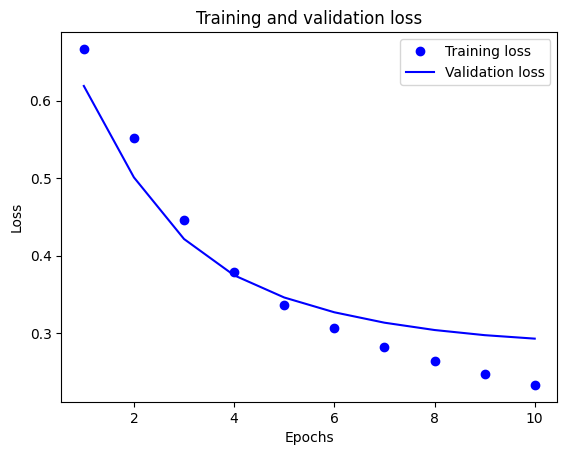

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

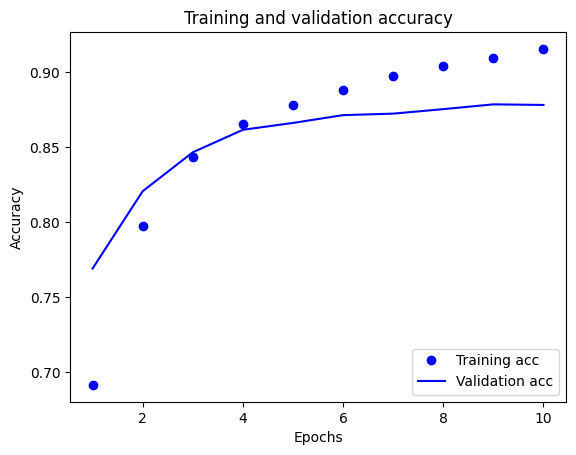

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

在该图表中，虚线代表训练损失和准确率，实线代表验证损失和准确率。

请注意，训练损失会逐周期*下降*，而训练准确率则逐周期*上升*。使用梯度下降优化时，这是预期结果，它应该在每次迭代中最大限度减少所需的数量。

但是，对于验证损失和准确率来说则不然——它们似乎会在训练转确率之前达到顶点。这是过拟合的一个例子：模型在训练数据上的表现要好于在之前从未见过的数据上的表现。经过这一点之后，模型会过度优化和学习*特定*于训练数据的表示，但无法*泛化*到测试数据。

对于这种特殊情况，您可以通过在验证准确率不再增加时直接停止训练来防止过度拟合。一种方式是使用 `tf.keras.callbacks.EarlyStopping` 回调。

## 导出模型

在上面的代码中，您在向模型馈送文本之前对数据集应用了 `TextVectorization`。 如果您想让模型能够处理原始字符串（例如，为了简化部署），您可以在模型中包含 `TextVectorization` 层。为此，您可以使用刚刚训练的权重创建一个新模型。

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 4:24 - loss: 0.1804 - accuracy: 0.9375

 14/782 [..............................] - ETA: 3s - loss: 0.3199 - accuracy: 0.8638  

 28/782 [>.............................] - ETA: 2s - loss: 0.3452 - accuracy: 0.8449

 42/782 [>.............................] - ETA: 2s - loss: 0.3181 - accuracy: 0.8631

 56/782 [=>............................] - ETA: 2s - loss: 0.3271 - accuracy: 0.8577

 70/782 [=>............................] - ETA: 2s - loss: 0.3193 - accuracy: 0.8598

 84/782 [==>...........................] - ETA: 2s - loss: 0.3235 - accuracy: 0.8583

 98/782 [==>...........................] - ETA: 2s - loss: 0.3178 - accuracy: 0.8597

112/782 [===>..........................] - ETA: 2s - loss: 0.3139 - accuracy: 0.8641

126/782 [===>..........................] - ETA: 2s - loss: 0.3175 - accuracy: 0.8646

140/782 [====>.........................] - ETA: 2s - loss: 0.3179 - accuracy: 0.8650

154/782 [====>.........................] - ETA: 2s - loss: 0.3150 - accuracy: 0.8667

168/782 [=====>........................] - ETA: 2s - loss: 0.3182 - accuracy: 0.8655

182/782 [=====>........................] - ETA: 2s - loss: 0.3152 - accuracy: 0.8678

196/782 [======>.......................] - ETA: 2s - loss: 0.3131 - accuracy: 0.8689

210/782 [=======>......................] - ETA: 2s - loss: 0.3136 - accuracy: 0.8699

224/782 [=======>......................] - ETA: 2s - loss: 0.3148 - accuracy: 0.8684

238/782 [========>.....................] - ETA: 2s - loss: 0.3146 - accuracy: 0.8699

252/782 [========>.....................] - ETA: 1s - loss: 0.3153 - accuracy: 0.8704

266/782 [=========>....................] - ETA: 1s - loss: 0.3137 - accuracy: 0.8721

280/782 [=========>....................] - ETA: 1s - loss: 0.3128 - accuracy: 0.8720

293/782 [==========>...................] - ETA: 1s - loss: 0.3118 - accuracy: 0.8724

306/782 [==========>...................] - ETA: 1s - loss: 0.3113 - accuracy: 0.8732

320/782 [===========>..................] - ETA: 1s - loss: 0.3123 - accuracy: 0.8729

334/782 [===========>..................] - ETA: 1s - loss: 0.3121 - accuracy: 0.8734

348/782 [============>.................] - ETA: 1s - loss: 0.3119 - accuracy: 0.8733

361/782 [============>.................] - ETA: 1s - loss: 0.3110 - accuracy: 0.8736

375/782 [=============>................] - ETA: 1s - loss: 0.3111 - accuracy: 0.8739

389/782 [=============>................] - ETA: 1s - loss: 0.3109 - accuracy: 0.8738

403/782 [==============>...............] - ETA: 1s - loss: 0.3096 - accuracy: 0.8745

416/782 [==============>...............] - ETA: 1s - loss: 0.3094 - accuracy: 0.8742

429/782 [===============>..............] - ETA: 1s - loss: 0.3100 - accuracy: 0.8738

443/782 [===============>..............] - ETA: 1s - loss: 0.3095 - accuracy: 0.8737

456/782 [================>.............] - ETA: 1s - loss: 0.3102 - accuracy: 0.8738

470/782 [=================>............] - ETA: 1s - loss: 0.3106 - accuracy: 0.8737

483/782 [=================>............] - ETA: 1s - loss: 0.3112 - accuracy: 0.8736

497/782 [==================>...........] - ETA: 1s - loss: 0.3113 - accuracy: 0.8732

510/782 [==================>...........] - ETA: 1s - loss: 0.3112 - accuracy: 0.8732

524/782 [===================>..........] - ETA: 0s - loss: 0.3105 - accuracy: 0.8734

537/782 [===================>..........] - ETA: 0s - loss: 0.3098 - accuracy: 0.8742

551/782 [====================>.........] - ETA: 0s - loss: 0.3089 - accuracy: 0.8747

565/782 [====================>.........] - ETA: 0s - loss: 0.3094 - accuracy: 0.8741

578/782 [=====================>........] - ETA: 0s - loss: 0.3089 - accuracy: 0.8744

592/782 [=====================>........] - ETA: 0s - loss: 0.3091 - accuracy: 0.8741

605/782 [======================>.......] - ETA: 0s - loss: 0.3095 - accuracy: 0.8743

618/782 [======================>.......] - ETA: 0s - loss: 0.3094 - accuracy: 0.8741

632/782 [=======================>......] - ETA: 0s - loss: 0.3098 - accuracy: 0.8740

645/782 [=======================>......] - ETA: 0s - loss: 0.3099 - accuracy: 0.8739

659/782 [========================>.....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8736

673/782 [========================>.....] - ETA: 0s - loss: 0.3101 - accuracy: 0.8735

687/782 [=========================>....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8737

701/782 [=========================>....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8734

714/782 [==========================>...] - ETA: 0s - loss: 0.3102 - accuracy: 0.8731

728/782 [==========================>...] - ETA: 0s - loss: 0.3095 - accuracy: 0.8735

742/782 [===========================>..] - ETA: 0s - loss: 0.3100 - accuracy: 0.8733

756/782 [============================>.] - ETA: 0s - loss: 0.3108 - accuracy: 0.8727

769/782 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8727

782/782 [==============================] - 3s 4ms/step - loss: 0.3107 - accuracy: 0.8732


0.8731600046157837


### 使用新数据进行推断

要获得对新样本的预测，只需调用 `model.predict()` 即可。

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 177ms/step


array([[0.5980279 ],
       [0.41937438],
       [0.33809566]], dtype=float32)

将文本预处理逻辑包含在模型中后，您可以导出用于生产的模型，从而简化部署并降低[训练/测试偏差](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)的可能性。

在选择应用 TextVectorization 层的位置时，需要注意性能差异。在模型之外使用它可以让您在 GPU 上训练时进行异步 CPU 处理和数据缓冲。因此，如果您在 GPU 上训练模型，您应该在开发模型时使用此选项以获得最佳性能，然后在准备好部署时进行切换，在模型中包含 TextVectorization 层。

请参阅此[教程](https://tensorflow.google.cn/tutorials/keras/save_and_load)，详细了解如何保存模型。

## 练习：对 Stack Overflow 问题进行多类分类

本教程展示了如何在 IMDB 数据集上从头开始训练二元分类器。作为练习，您可以修改此笔记本以训练多类分类器来预测 [Stack Overflow](http://stackoverflow.com/) 上的编程问题的标签。

我们已经准备好了一个[数据集](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)供您使用，其中包含了几千个发布在 Stack Overflow 上的编程问题（例如，"How can sort a dictionary by value in Python?"）。每一个问题都只有一个标签（Python、CSharp、JavaScript 或 Java）。您的任务是将问题作为输入，并预测适当的标签，在本例中为 Python。

您将使用的数据集包含从 [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) 上更大的公共 Stack Overflow 数据集提取的数千个问题，其中包含超过 1700 万个帖子。

下载数据集后，您会发现它与您之前使用的 IMDB 数据集具有相似的目录结构：

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

注：为了增加分类问题的难度，编程问题中出现的 Python、CSharp、JavaScript 或 Java 等词已被替换为 *blank*（因为许多问题都包含它们所涉及的语言）。

要完成此练习，您应该对此笔记本进行以下修改以使用 Stack Overflow 数据集：

1. 在笔记本顶部，将下载 IMDB 数据集的代码更新为下载前面准备好的 [Stack Overflow 数据集](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)的代码。由于 Stack Overflow 数据集具有类似的目录结构，因此您不需要进行太多修改。

2. 将模型的最后一层修改为 `Dense(4)`，因为现在有四个输出类。

3. 编译模型时，将损失更改为 `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`。当每个类的标签是整数（在本例中，它们可以是 0、*1*、*2* 或 *3*）时，这是用于多类分类问题的正确损失函数。 此外，将指标更改为 `metrics=['accuracy']`，因为这是一个多类分类问题（`tf.metrics.BinaryAccuracy` 仅用于二元分类器 ）。

4. 在绘制随时间变化的准确率时，请将 `binary_accuracy` 和 `val_binary_accuracy` 分别更改为 `accuracy` 和 `val_accuracy`。

5. 完成这些更改后，就可以训练多类分类器了。 

## 了解更多信息

本教程从头开始介绍了文本分类。要详细了解一般的文本分类工作流程，请查看 Google Developers 提供的[文本分类指南](https://developers.google.com/machine-learning/guides/text-classification/)。
